###  json 파일로부터 입력 받아오기
non_real_tasks와 real_tasks로 구분해서 분리  

In [77]:
import json
import matplotlib.pyplot as plot
import pandas as pa
import math
import os
from queue import PriorityQueue
path = './inputs/'
file_list = os.listdir(path)
dataframe = []
non_real_tasks = []
real_tasks = []
for json_file in file_list:
    with open(path+json_file, 'r') as f:  #[file]에 파일 제목 입력
        file = json.load(f)
    dataframe.append(file)

for data in dataframe:
    non_real_tasks.append(data["non_real_tasks"])
    real_tasks.append(data["real_tasks"])


### 선입 선처리 
도착시간을 기준으로 먼저 온 테스크부터 처리한다

In [78]:
def fcfs(tasks):
    # 도착시간을 기준으로 테스크를 정렬
    tasks.sort(key=lambda x : x['arrival_time'])
    priority = [task['priority'] for task in tasks]
    processes = [task['name'] for task in tasks] 
    arrival_time = [task['arrival_time'] for task in tasks]
    burst_time = [task['burst_time'] for task in tasks]
    n = len(tasks)
    
    waiting_time = [0] * n
    turnaround_time = [0] * n
    response_time = [0] * n
    context_switch = 0
    start_time = [[] for _ in range(n)]
    cycle_time = [[] for _ in range(n)] 
    time = 0
    
    ready_queue=[]
    not_arrive_queue=[]
    
    # 큐 초기화
    if arrival_time[0]==0:
        ready_queue.append(0)
        for i in range(1,n,1) :
            not_arrive_queue.append(i) 
    else :
        for i in range(n):
            not_arrive_queue.append(i)
            
    while True :
        
        if len(ready_queue) == 0 :
            if len(not_arrive_queue)==0 :
                break
        
            else :
                current_process = not_arrive_queue.pop(0)
                if time >= arrival_time[current_process]:
                    ready_queue.append(current_process)
                else :
                    while time != arrival_time[current_process] :
                        time += 1
                    ready_queue.append(current_process)
        else :
            current_process = ready_queue.pop(0)   
            waiting_time[current_process] = time - arrival_time[current_process]
            start_time[current_process].append(time)
            cycle_time[current_process].append(burst_time[current_process])
            response_time[current_process] = time - arrival_time[current_process] #선입 선처리에선 응답시간은 대기시간과 동일
            time += burst_time[current_process]
            turnaround_time[current_process] = waiting_time[current_process] + burst_time[current_process]
    return context_switch , n/sum(turnaround_time) , sum(turnaround_time)/n , sum(waiting_time)/n , sum(response_time)/n,start_time,cycle_time,processes


### 최단 작업 우선 비선점형
작업시간이 짧은 것부터 처리하지만 먼저 들어온 것을 비선점으로 처리하게 처음에
들어온 것이 매우 크다면 호위현상이 발생할 수도 있다

In [79]:
def np_sjf(tasks):
    # 작업시간을 기준으로 테스크를 정렬
    tasks.sort(key=lambda x : x['burst_time'])
    priority = [task['priority'] for task in tasks]
    processes = [task['name'] for task in tasks]
    arrival_time = [task['arrival_time'] for task in tasks]
    burst_time = [task['burst_time'] for task in tasks]
    n = len(tasks)
    waiting_time = [0] * n
    turnaround_time = [0] * n
    start_time = [[] for _ in range(n)]
    cycle_time = [[] for _ in range(n)] 
    response_time = [0] * n
    context_switch = 0
    time = 0
    
    ready_queue=[]
    not_arrive_queue=[]
    
    # 큐 초기화
    for i in range(n):
        if arrival_time[i]==0:
            ready_queue.append(i)
        else :
            not_arrive_queue.append(i)
    
    while True :
        
        if len(ready_queue) == 0 :
            if len(not_arrive_queue)==0 :
                break
        
            else :
                while True :
                    remove_list=[]
                    for i in not_arrive_queue :  # 작업시간을 기준을 정렬된 것들이 우선적으로 들어가기에 짧은 것부터 처리하게 됨
                        if time >= arrival_time[i] :
                            ready_queue.append(i)
                            remove_list.append(i)
                    for i in remove_list :
                        not_arrive_queue.remove(i)
                    if len(ready_queue)!=0 :
                        break
                    else :
                        time += 1
                
        else :
            current_process = ready_queue.pop(0)   
            waiting_time[current_process] = time - arrival_time[current_process]
            response_time[current_process] = time - arrival_time[current_process]
            start_time[current_process].append(time)
            cycle_time[current_process].append(burst_time[current_process])
            time += burst_time[current_process]
            turnaround_time[current_process] = waiting_time[current_process] +burst_time[current_process]
    return context_switch , n/sum(turnaround_time) , sum(turnaround_time)/n , sum(waiting_time)/n , sum(response_time)/n,start_time,cycle_time,processes      

### 최단 작업 우선 선점형
만약 더 짧은 작업시간을 가진 것이 들어온다면 선점한다  
호위현상을 막을 수 있다

In [80]:
def p_sjf(tasks):
    # 작업시간을 기준으로 테스크를 정렬
    tasks.sort(key=lambda x : x['burst_time'])
    priority = [task['priority'] for task in tasks]
    processes = [task['name'] for task in tasks]
    arrival_time = [task['arrival_time'] for task in tasks]
    burst_time = [task['burst_time'] for task in tasks]
    remaining_burst_time = burst_time.copy()
    n = len(tasks)
    waiting_time = [0] * n
    turnaround_time = [0] * n
    start_time = [[] for _ in range(n)]
    cycle_time = [[] for _ in range(n)] 
    response_time = [0] * n
    context_switch = 0
    time = 0
    
    ready_queue=[]
    not_arrive_queue=[]
    
    # 큐 초기화
    for i in range(n):
        if arrival_time[i]==0:
            ready_queue.append((burst_time[i],i))
        else :
            not_arrive_queue.append(i)
    
    while True :
        
        if len(ready_queue) == 0 :
            if len(not_arrive_queue)==0 :
                break
        
            else :
                while True :
                    remove_list=[]
                    for i in not_arrive_queue :
                        if time >= arrival_time[i] :
                            ready_queue.append((burst_time[i],i))
                            remove_list.append(i)
                    for i in remove_list :
                        not_arrive_queue.remove(i)
                    if len(ready_queue)!=0 :
                        break
                    else :
                        time += 1
                
        else :
            ready_queue.sort()
            idx = ready_queue.pop(0)
            current_process = idx[1] 
            bursting_time = 0
            to_change = False
            for i in range(remaining_burst_time[current_process]) :
                remove_list=[]
                start_time[current_process].append(time)
                time += 1
                bursting_time += 1
                cycle_time[current_process].append(1)
                for process in ready_queue :
                    waiting_time[process[1]] += 1
                for i in not_arrive_queue :
                    if time >= arrival_time[i] :
                        ready_queue.append((burst_time[i],i))
                        remove_list.append(i)
                        if burst_time[i] < burst_time[current_process] : # 작업시간이 더 짧은 프로세스가 선점
                            to_change =True
                for i in remove_list :
                    not_arrive_queue.remove(i)
                if to_change :
                    context_switch += 1
                    remaining_burst_time[current_process] -= bursting_time
                    ready_queue.append((burst_time[current_process],current_process))
                    break
           # for문이 정상적으로 끝난다면 해당 프로세스가 끝이난 것 총처리시간 계산
            if  to_change == False :
                remaining_burst_time[current_process] = 0
                turnaround_time[current_process] = waiting_time[current_process] + burst_time[current_process] 
                    
    for i in range(n):
        response_time[i] = start_time[i][0] - arrival_time[i]  
    return context_switch , n/sum(turnaround_time) , sum(turnaround_time)/n , sum(waiting_time)/n , sum(response_time)/n,start_time,cycle_time,processes              
    

### 비선점형 최소 잔여시간
비선점형 최단 작업 우선시간과 동일하다

In [81]:
def np_srjf(tasks):
    # 작업시간을 기준으로 테스크를 정렬
    tasks.sort(key=lambda x : x['burst_time'])
    priority = [task['priority'] for task in tasks]
    processes = [task['name'] for task in tasks]
    arrival_time = [task['arrival_time'] for task in tasks]
    burst_time = [task['burst_time'] for task in tasks]    
    n = len(tasks)
    waiting_time = [0] * n 
    turnaround_time = [0] * n
    response_time = [0] * n
    context_switch = 0
    start_time = [[] for _ in range(n)]
    cycle_time = [[] for _ in range(n)] 
    time = 0
    ready_queue=PriorityQueue() #작업시간이 남은 것을 기준으로 하는 우선순위 큐 짧을 수록 앞으로 온다
    not_arrive_queue=[]
    
    # 큐 초기화
    for i in range(n):
        if arrival_time[i]==0:
            ready_queue.put((burst_time[i],i))
        else :
            not_arrive_queue.append(i)
    
    while True :
        
        if ready_queue.qsize() == 0 :
            if len(not_arrive_queue)==0 :
                break
        
            else :
                while True :
                    remove_list=[]
                    for i in not_arrive_queue :
                        if time >= arrival_time[i] :
                            ready_queue.put((burst_time[i],i))
                            remove_list.append(i)
                    for i in remove_list :
                        not_arrive_queue.remove(i)
                    if ready_queue.qsize()!=0 :
                        break
                    else :
                        time += 1
                
        else :
            remove_list=[]
            index = ready_queue.get()[0:]  
            remaining_burst_time = index[0]
            current_process =  index[1]
            start_time[current_process].append(time)
            waiting_time[current_process] += time - arrival_time[current_process]
            time += remaining_burst_time
            turnaround_time[current_process] = waiting_time[current_process] + burst_time[current_process]
            cycle_time[current_process].append(remaining_burst_time)
            for j in not_arrive_queue :
                if time >= arrival_time[j] :
                    if remaining_burst_time > burst_time[j]:
                        ready_queue.put((burst_time[j],j))
                        remove_list.append(j)
                    else :
                        ready_queue.put((burst_time[j],j))
                        remove_list.append(j)
            for j in remove_list :
                not_arrive_queue.remove(j)
    
    for i in range(n):
        response_time[i] = start_time[i][0] - arrival_time[i]
    return context_switch , n/sum(turnaround_time) , sum(turnaround_time)/n , sum(waiting_time)/n , sum(response_time)/n,start_time,cycle_time,processes

### 최소 잔여시간 우선 선점형

<먼저 들어온 것이 크더라도 계속 비교해가면서 선점적으로 짧은 것을 우선적으로 처리한다>

In [82]:
def p_srjf(tasks):
    # 작업시간을 기준으로 테스크를 정렬
    tasks.sort(key=lambda x : x['burst_time'])
    priority = [task['priority'] for task in tasks]
    processes = [task['name'] for task in tasks]
    arrival_time = [task['arrival_time'] for task in tasks]
    burst_time = [task['burst_time'] for task in tasks]    
    n = len(tasks)
    waiting_time = [0] * n 
    turnaround_time = [0] * n
    response_time = [0] * n
    context_switch = 0
    start_time = [[] for _ in range(n)]
    cycle_time = [[] for _ in range(n)] 
    time = 0
    ready_queue=PriorityQueue()
    not_arrive_queue=[]
    
    # 큐 초기화
    for i in range(n):
        if arrival_time[i]==0:
            ready_queue.put((burst_time[i],i,0))
        else :
            not_arrive_queue.append(i)
    
    while True :
        
        if ready_queue.qsize() == 0 :
            if len(not_arrive_queue)==0 :
                break
        
            else :
                while True :
                    remove_list=[]
                    for i in not_arrive_queue :
                        if time >= arrival_time[i] :
                            ready_queue.put((burst_time[i],i,0))
                            remove_list.append(i)
                    for i in remove_list :
                        not_arrive_queue.remove(i)
                    if ready_queue.qsize()!=0 :
                        break
                    else :
                        time += 1
                
        else :
            # 더 이상의 들어올 것이 없으므로 비교를 할 필요가 없음 우선순위큐에 들어있는 순대로 처리하면 됨 선입선처리처럼
            if len(not_arrive_queue) == 0 :
                
                index = ready_queue.get()[0:]  
                remaining_burst_time = index[0]
                current_process =  index[1]
                bursted_time = index[2]
                start_time[current_process].append(time)
                waited_time = waiting_time[current_process]
                waiting_time[current_process] += time - arrival_time[current_process] - bursted_time - waited_time
                time += remaining_burst_time
                turnaround_time[current_process] = waiting_time[current_process] + burst_time[current_process]
                cycle_time[current_process].append(remaining_burst_time)
            # 1초 단위로 not_arrive_queue에서 넣을 수 있는 것이 있음 넣고 비교 처리
            else :
                index = ready_queue.get()[0:]  
                remaining_burst_time = index[0]
                current_process =  index[1]
                bursted_time = index[2]
                bursting_time = 0
                to_change = False
                waited_time = waiting_time[current_process]
                waiting_time[current_process] += time - arrival_time[current_process] - bursted_time - waited_time

                for i in range(index[0]) :
                    remove_list = []
                    start_time[current_process].append(time)
                    time += 1
                    bursting_time += 1
                    remaining_burst_time -= 1
                    cycle_time[current_process].append(1)
                    for j in not_arrive_queue :
                        if time >= arrival_time[j] :
                            if remaining_burst_time > burst_time[j]: # 남아있는 작업시간이 더 길다면 선점당한다.
                                ready_queue.put((burst_time[j],j,0))
                                to_change=True
                                remove_list.append(j)
                            else :
                                ready_queue.put((burst_time[j],j,0))
                                remove_list.append(j)
                    for j in remove_list :
                        not_arrive_queue.remove(j)
                    if to_change :
                        context_switch += 1
                        ready_queue.put((remaining_burst_time,current_process,bursting_time)) # 동적으로 잔존 작업시간 판단 
                        break
                    
                # for문이 정상적으로 끝난다면 해당 프로세스가 끝이난 것 총처리시간 계산
                if  to_change == False :
                    turnaround_time[current_process] = waiting_time[current_process] + burst_time[current_process]
    
    for i in range(n):
        response_time[i] = start_time[i][0] - arrival_time[i]
        
    return context_switch , n/sum(turnaround_time) , sum(turnaround_time)/n , sum(waiting_time)/n , sum(response_time)/n,start_time,cycle_time,processes
    

### 라운드 로빈
이분 탐색으로 적절한 퀀텀 할당량을 찾는다  
가장 총처리 시간이 짧게 나오는 퀀텀을 고른다  

In [83]:
def round_robin(tasks):
    # 도착시간을 기준으로 테스크를 정렬
    tasks.sort(key=lambda x : x['arrival_time'])
    priority = [task['priority'] for task in tasks]
    processes = [task['name'] for task in tasks]
    arrival_time = [task['arrival_time'] for task in tasks]
    burst_time = [task['burst_time'] for task in tasks]
    n = len(tasks)
    quantum_time = 1
    response_time = [0] * n
    context_switch = 0
    def find_quantum():
        # 퀀텀 값의 범위를 최솟값을 1초 최댓값을 가장 오래걸리는 task burst time으로 설정
        left, right = 1, max(burst_time)
        deadline = 987654321
        quantum_time = 1
        while left <= right:
            mid = (left + right) // 2

            # 모든 프로세스를 시뮬레이션하여 종료 시간 계산
            end_times = simulate_quantum(mid)
            avg_turnaround_time = sum(end_times[1])/n
            # 평균 총처리시간을 비교 기존의 것보다 크면 퀀텀 값을 줄여서 재 탐색
            if  avg_turnaround_time> deadline:
                right = mid - 1
            # 평균 총처리시간을 비교 기존의 것보다 작거나 같으면 퀀텀 값을 키워서 재 탐색
            else:
                deadline = avg_turnaround_time 
                # 평균 총처리 시간이 가장 짧은 퀀텀을 탐색
                quantum_time = mid
                left = mid + 1           
        return quantum_time

    def simulate_quantum(quantum):
        context_switch_time = 0
        remaining_burst_time = burst_time.copy()
        waiting_time = [0] * n
        turnaround_time = [0] * n
        time = 0
        start_time = [[] for _ in range(n)]
        cycle_time = [[] for _ in range(n)] 
        
        ready_queue=[]
        not_arrive_queue=[]
        
        for i in range(n):
            if arrival_time[i]==0:
                ready_queue.append(i)
            else :
                not_arrive_queue.append(i)
        
        while True:
            
            if len(ready_queue) == 0 :
                if len(not_arrive_queue)==0 :
                    break
                
                else :
                    while True :
                        remove_list=[]
                        for i in not_arrive_queue :
                            if time >= arrival_time[i] :
                                ready_queue.append(i)
                                remove_list.append(i)
                        for i in remove_list :
                            not_arrive_queue.remove(i)
                        if len(ready_queue)!=0 :
                            break
                        else :
                            time += 1
                
            else :
                current_process = ready_queue.pop(0)
                current_burst_time = remaining_burst_time[current_process]
                
                if current_burst_time <= quantum:
                    for i in ready_queue:
                        waiting_time[i] += current_burst_time
                    start_time[current_process].append(time)
                    time += current_burst_time
                    cycle_time[current_process].append(remaining_burst_time[current_process])
                    remaining_burst_time[current_process] = 0
                    turnaround_time[current_process] = time - arrival_time[current_process]
                    # 도착했으면 바로바로 넣어주기
                    remove_list=[]
                    for i in not_arrive_queue :
                        if time >= arrival_time[i] :
                            ready_queue.append(i)
                            remove_list.append(i)
                            waiting_time[i] += current_burst_time - arrival_time[i]
                    for i in remove_list :
                        not_arrive_queue.remove(i)
                        
                else:
                    for i in ready_queue:
                        waiting_time[i] += quantum
                    start_time[current_process].append(time)
                    time += quantum
                    cycle_time[current_process].append(quantum)
                    remaining_burst_time[current_process] -= quantum                 
                    # 도착했으면 바로바로 넣어주기
                    remove_list=[]
                    for i in not_arrive_queue :
                        if time >= arrival_time[i] :
                            ready_queue.append(i)
                            remove_list.append(i)
                            waiting_time[i] += quantum - arrival_time[i]
                    for i in remove_list :
                        not_arrive_queue.remove(i)
                    if len(ready_queue) != 0 : # 0개면 문맥교환이 없다
                        context_switch_time += 1
                    ready_queue.append(current_process) # 잔여시간이 있으니 다시 큐에 넣는다
                
                
        return waiting_time,turnaround_time, start_time, cycle_time, context_switch_time

    quantum_time = find_quantum()
    result = simulate_quantum(quantum_time)
    waiting_time = result[0]
    turnaround_time = result[1]
    start_time = result[2]
    cycle_time = result[3]
    context_switch = result[4]
    
    for i in range(n):
        response_time[i] = start_time[i][0] - arrival_time[i]
    
    return context_switch , n/sum(turnaround_time) , sum(turnaround_time)/n , sum(waiting_time)/n , sum(response_time)/n, start_time,cycle_time,processes

### 비선점형 우선순위 스케줄링
비선점적으로 우선순위가 높은 것부터 처리 

우선순위가 같다면 선입선처리

비선점적 방식이기에 에이징이 없고 기아현상이 발생할 수 있다

In [84]:
def np_priority_scheduling(tasks) :
    # 우선순위을 기준으로 테스크를 정렬
    tasks.sort(key=lambda x : x['priority'])
    priority = [task['priority'] for task in tasks]
    processes = [task['name'] for task in tasks]
    arrival_time = [task['arrival_time'] for task in tasks]
    burst_time = [task['burst_time'] for task in tasks]    
    n = len(tasks)
    waiting_time = [0] * n 
    turnaround_time = [0] * n
    response_time = [0] * n
    context_switch = 0
    start_time = [[] for _ in range(n)]
    cycle_time = [[] for _ in range(n)] 
    time = 0
    ready_queue = []
    not_arrive_queue=[]
    
    # 큐 초기화
    for i in range(n):
        if arrival_time[i]==0:
            ready_queue.append((priority[i],i))
        else :
            not_arrive_queue.append(i)
    
    while True :
        
        if len(ready_queue) == 0 :
            if len(not_arrive_queue)==0 :
                break
        
            else :
                while True :
                    remove_list=[]
                    for i in not_arrive_queue :
                        if time >= arrival_time[i] :
                            ready_queue.append((priority[i],i))
                            remove_list.append(i)
                    for i in remove_list :
                        not_arrive_queue.remove(i)
                    if ready_queue.qsize()!=0 :
                        break
                    else :
                        time += 1
                
        else :
            ready_queue.sort()
            index = ready_queue.pop(0) 
            current_process =  index[1]
            remove_list = []
            start_time[current_process].append(time)
            waiting_time[current_process] = time - arrival_time[current_process]
            time += burst_time[current_process]
            cycle_time[current_process].append(burst_time[current_process])

            for j in not_arrive_queue :
                if time >= arrival_time[j] :
                    ready_queue.append((priority[j],j))
                    remove_list.append(j)
            for j in remove_list :
                not_arrive_queue.remove(j)
            turnaround_time[current_process] = waiting_time[current_process] + burst_time[current_process]
    
    for i in range(n):
        response_time[i] = start_time[i][0] - arrival_time[i]  
    return context_switch , n/sum(turnaround_time) , sum(turnaround_time)/n , sum(waiting_time)/n , sum(response_time)/n,start_time,cycle_time,processes   

### 선점형 우선순위 스케줄링

도착한 순서대로 처리하다가 우선순위가 높은 것이 오면 높은 우선순위 테스크가 선점 

우선순위가 같으면 선입선출

기아 현상 발생 방지를 위해 waiting_time >= burst_time이 되면 우선 순위를 한단계 높여준다

waiting_time >= burst_time이 됐는데 서로 우선순위가 같다면 현재 cpu를 점유하는 테스크를 내리고 우선순위를 한단계 내린다

In [85]:
def p_priority_scheduling(tasks) :
    # 우선순위을 기준으로 테스크를 정렬
    tasks.sort(key=lambda x : x['priority'])
    priority = [task['priority'] for task in tasks]
    processes = [task['name'] for task in tasks]
    arrival_time = [task['arrival_time'] for task in tasks]
    burst_time = [task['burst_time'] for task in tasks]    
    n = len(tasks)
    waiting_time = [0] * n 
    remaining_burst_time = burst_time.copy()
    current_waiting_time = [0] * n
    turnaround_time = [0] * n
    response_time = [0] * n
    context_switch = 0
    start_time = [[] for _ in range(n)]
    cycle_time = [[] for _ in range(n)] 
    time = 0
    ready_queue = []
    not_arrive_queue=[]
    
    # 큐 초기화
    for i in range(n):
        if arrival_time[i]==0:
            ready_queue.append((priority[i],i))
        else :
            not_arrive_queue.append(i)
    
    while True :
        
        if len(ready_queue) == 0 :
            if len(not_arrive_queue)==0 :
                break
        
            else :
                while True :
                    remove_list=[]
                    for i in not_arrive_queue :
                        if time >= arrival_time[i] :
                            ready_queue.append((priority[i],i))
                            remove_list.append(i)
                    for i in remove_list :
                        not_arrive_queue.remove(i)
                    if ready_queue.qsize()!=0 :
                        break
                    else :
                        time += 1
                
        else :
            ready_queue.sort()
            index = ready_queue.pop(0) 
            current_process =  index[1]
            current_process_priority = index[0]
            to_change = False
            bursting_time = 0
            for i in range(remaining_burst_time[current_process]) :
            
                remove_list = []
                relocate_list = []
                start_time[current_process].append(time)
                time += 1
                bursting_time += 1 
                cycle_time[current_process].append(1)
                for process in ready_queue :
                    waiting_time[process[1]] += 1
                    current_waiting_time[process[1]] += 1
                    if current_waiting_time[process[1]] >= burst_time[process[1]] : #현재 우선순위에서 대기한 시간이 burst_time을 넘어가면 우선순위를 높인다..
                        current_waiting_time[process[1]] = 0
                        relocate_list.append((process[0],process[1]))
                        if priority[process[1]] -1 >=0:
                            priority[process[1]] -= 1
                        else :
                            if current_process_priority == 0 :
                                current_process_priority += 1 # 둘다 최고 우선순위일 경우 현재 돌고있는 테스크의 우선순위를 한단계 낮춰준다
                        if priority[process[1]] < current_process_priority :
                            to_change =True
                for j in not_arrive_queue :
                    if time >= arrival_time[j] :
                        if current_process_priority > priority[j]:
                            ready_queue.append((priority[j],j))
                            to_change=True
                            remove_list.append(j)
                        else :
                            ready_queue.append((priority[j],j))
                            remove_list.append(j)
                for j in relocate_list :
                    ready_queue.remove(j)
                    ready_queue.append((priority[j[1]],j[1]))
                for j in remove_list :
                    not_arrive_queue.remove(j)
                if to_change :
                    context_switch += 1
                    remaining_burst_time[current_process] -= bursting_time
                    ready_queue.append((current_process_priority,current_process))
                    break
                
            # for문이 정상적으로 끝난다면 해당 프로세스가 끝이난 것 총처리시간 계산
            if  to_change == False :
                remaining_burst_time[current_process] = 0
                turnaround_time[current_process] = waiting_time[current_process] + burst_time[current_process]
    
    for i in range(n):
        response_time[i] = start_time[i][0] - arrival_time[i]  
    return context_switch , n/sum(turnaround_time) , sum(turnaround_time)/n , sum(waiting_time)/n , sum(response_time)/n,start_time,cycle_time,processes           

### 다단계 큐 스케줄링

같은 우선순위끼리 큐에 넣고  
위에 우선순위가 끝나면 하위 단계 큐가 진행되는 방식

우선순위로 나눠진 큐 내에서 라운드로빈이 아닌 최소 잔여시간 우선 방식으로 해결


In [86]:
def srjf_multi_queue(tasks):
   # 우선순위을 기준으로 테스크를 정렬
    tasks.sort(key=lambda x : x['priority'])
    priority = [task['priority'] for task in tasks]
    processes = [task['name'] for task in tasks]
    arrival_time = [task['arrival_time'] for task in tasks]
    burst_time = [task['burst_time'] for task in tasks]    
    n = len(tasks)
    bursted_time= [0] * n
    waiting_time = [0] * n
    turnaround_time = [0] * n
    response_time = [0] * n
    context_switch = 0
    start_time = [[] for _ in range(n)]
    cycle_time = [[] for _ in range(n)] 
    time = 0
    max_priority = max(priority)+1
    ready_queue= [PriorityQueue() for _ in range(max_priority)]
    not_arrive_queue=[]
    
    # ready_queue empty 판별 함수
    def is_empty(queues):
        for queue in queues:
            if queue.qsize() != 0:
                return False
        return True
    # ready_queue pop 함수 가능한 한 상위 큐 그리고 상위 큐 중에서도 가장 앞에 것을 반환
    def pop(queues) :
        for queue in queues :
            if queue.qsize()==0 :
                continue
            else : 
                return queue.get()
    
    # 큐 초기화
    for i in range(n):
        if arrival_time[i]==0:
            ready_queue[priority[i]].put((burst_time[i],i,0))
        else :
            not_arrive_queue.append(i)
    
    while True :
        
        if is_empty(ready_queue) :
            if len(not_arrive_queue)==0 :
                break
        
            else :
                while True :
                    remove_list=[]
                    for i in not_arrive_queue :
                        if time >= arrival_time[i] :
                            ready_queue[priority[i]].put((burst_time[i],i,0))
                            remove_list.append(i)
                    for i in remove_list :
                        not_arrive_queue.remove(i)
                    if is_empty(ready_queue) == False :
                        break
                    else :
                        time += 1
                
        else :
            # 더 이상의 들어올 것이 없으므로 비교를 할 필요가 없음 상위 큐로부터 내려오면서 처리하면 됨
            if len(not_arrive_queue) == 0 :
                
                index = pop(ready_queue)  
                remaining_burst_time = index[0]
                current_process =  index[1]
                bursted_time = index[2]
                waited_time = waiting_time[current_process]
                waiting_time[current_process] += time - arrival_time[current_process] - bursted_time - waited_time
                start_time[current_process].append(time)
                time += remaining_burst_time
                turnaround_time[current_process] = waiting_time[current_process] + burst_time[current_process] 
                cycle_time[current_process].append(remaining_burst_time)
            # 1초 단위로 not_arrive_queue에서 넣을 수 있는 것이 있음 넣고 비교 처리
            # 비교는 총 2번 같은 priority면 잔여시간 짧은 것이 우선
            # 들어오는 작업의 priority가 더 높으면 그 작업을 택함
            else :
                index = pop(ready_queue)  
                remaining_burst_time = index[0]
                current_process =  index[1]
                bursted_time = index[2]
                bursting_time = 0
                current_process_priority = priority[current_process]
                to_change = False
                waited_time = waiting_time[current_process]
                waiting_time[current_process] += time - arrival_time[current_process] - bursted_time - waited_time
                for i in range(index[0]) :
                    remove_list = []
                    start_time[current_process].append(time)
                    time += 1
                    bursting_time += 1
                    remaining_burst_time -= 1
                    cycle_time[current_process].append(1)
                    for j in not_arrive_queue :
                        if time >= arrival_time[j] :
                            if current_process_priority > priority[j]:
                                ready_queue[priority[j]].put((burst_time[j],j,0))
                                to_change=True
                                remove_list.append(j)
                                
                            elif current_process_priority == priority[j]:
                                if remaining_burst_time > burst_time[j] :
                                    ready_queue[priority[j]].put((burst_time[j],j,0))
                                    to_change=True
                                    remove_list.append(j)
                            else :
                                ready_queue[priority[j]].put((burst_time[j],j,0))
                                remove_list.append(j)
                    for j in remove_list :
                        not_arrive_queue.remove(j)
                    if to_change :
                        context_switch += 1
                        ready_queue[current_process_priority].put((remaining_burst_time,current_process,bursting_time))
                        break
                    
                # for문이 정상적으로 끝난다면 해당 프로세스가 끝이난 것 총처리시간 계산
                if  to_change == False :
                    turnaround_time[current_process] = waiting_time[current_process] + burst_time[current_process]
    
    for i in range(n):
        response_time[i] = start_time[i][0] - arrival_time[i] 
        
    return context_switch , n/sum(turnaround_time) , sum(turnaround_time)/n , sum(waiting_time)/n , sum(response_time)/n,start_time,cycle_time,processes           


우선순위로 나누어진 큐 내에서 라운드로빈 방식으로 해결

In [87]:
def round_robin_multi_queue(tasks):
    # 우선순위 기준으로 테스크 정렬
    tasks.sort(key=lambda x : x['priority'])
    priority = [task['priority'] for task in tasks]
    processes = [task['name'] for task in tasks]
    arrival_time = [task['arrival_time'] for task in tasks]
    burst_time = [task['burst_time'] for task in tasks]
    max_priority = max(priority)+1
    n = len(tasks)
    quantum_time = 1
    response_time = [0] * n
    context_switch = 0
    
    # ready_queue empty 판별 함수
    def is_empty(queues):
        for queue in queues:
            if len(queue) != 0:
                return False
        return True
    # ready_queue pop 함수 가능한 한 상위 큐 그리고 상위 큐 중에서도 가장 앞에 것을 반환
    def pop(queues) :
        for queue in queues :
            if len(queue)==0 :
                continue
            else : 
                return queue.pop(0)
            
    def find_quantum():
        # 퀀텀 값의 범위를 최솟값을 1초 최댓값을 가장 오래걸리는 task burst time으로 설정
        left, right = 1, max(burst_time)
        deadline = 987654321
        quantum_time = 1
        while left <= right:
            mid = (left + right) // 2

            # 모든 프로세스를 시뮬레이션하여 종료 시간 계산
            end_times = simulate_quantum(mid)
            avg_turnaround_time = sum(end_times[1])/n
            # 평균 총처리시간을 비교 기존의 것보다 크면 퀀텀 값을 줄여서 재 탐색
            if  avg_turnaround_time> deadline:
                right = mid - 1
            # 평균 총처리시간을 비교 기존의 것보다 작거나 같으면 퀀텀 값을 키워서 재 탐색
            else:
                deadline = avg_turnaround_time 
                # 평균 총처리 시간이 가장 짧은 퀀텀을 탐색
                quantum_time = mid
                left = mid + 1           
        return quantum_time
    def simulate_quantum(quantum):
        
        context_switch_time = 0
        remaining_burst_time = burst_time.copy()
        waiting_time = [0] * n
        turnaround_time = [0] * n
        time = 0
        start_time = [[] for _ in range(n)]
        cycle_time = [[] for _ in range(n)] 
        ready_queue=[[] for _ in range(max_priority)]
        not_arrive_queue=[]
        for i in range(n):
            if arrival_time[i]==0:
                ready_queue[priority[i]].append(i)
            else :
                not_arrive_queue.append(i)
        while True:
            if is_empty(ready_queue) :
                if len(not_arrive_queue)==0 :
                    break
                
                else :
                    while True :
                        remove_list=[]
                        for i in not_arrive_queue :
                            if time >= arrival_time[i] :
                                ready_queue[priority[i]].append(i)
                                remove_list.append(i)
                        for i in remove_list :
                            not_arrive_queue.remove(i)
                        if is_empty(ready_queue) == False :
                            break
                        else :
                            time += 1
                
            else :
                current_process = pop(ready_queue)
                current_burst_time = remaining_burst_time[current_process]
                bursting_time = 0
                to_change = False
                if len(not_arrive_queue) == 0 :
                    if current_burst_time <= quantum:
                        start_time[current_process].append(time)
                        for queue in ready_queue :
                            for process in queue :
                                waiting_time[process] += current_burst_time
                        time += current_burst_time
                        cycle_time[current_process].append(current_burst_time)
                        remaining_burst_time[current_process] = 0           
                        turnaround_time[current_process] = waiting_time[current_process] + burst_time[current_process]
                    else:
                        if len(ready_queue[priority[current_process]]) !=0: # 0이면 문맥교환이 필요없다.
                            context_switch_time += 1                 
                        start_time[current_process].append(time)
                        time += quantum
                        cycle_time[current_process].append(quantum)
                        remaining_burst_time[current_process] -= quantum
                        for queue in ready_queue :
                            for process in queue :
                                waiting_time[process] += quantum
                        ready_queue[priority[current_process]].append(current_process) # 잔여시간이 있으니 다시 큐에 넣는다    
                else : 
                    if current_burst_time <= quantum:
                        for i in range(current_burst_time):
                            remove_list=[]
                            start_time[current_process].append(time)
                            time += 1
                            bursting_time += 1
                            cycle_time[current_process].append(1)
                            remaining_burst_time[current_process] -= 1
                            for queue in ready_queue :
                                for process in queue :
                                    waiting_time[process] += 1
                            for process in not_arrive_queue :
                                if time >= arrival_time[process] :
                                    ready_queue[priority[process]].append(process)
                                    remove_list.append(process)
                                    if priority[current_process] > priority[process] :
                                        to_change =True
                            if to_change :
                                context_switch_time += 1
                                ready_queue[priority[current_process]].append(current_process)
                                break
                            for to_remove_process in remove_list :
                                not_arrive_queue.remove(to_remove_process)
                        # for문이 정상적으로 끝났다면
                        if to_change == False :
                            turnaround_time[current_process] = waiting_time[current_process] + burst_time[current_process]
                    else:
                        for i in range(quantum):
                            remove_list=[]
                            start_time[current_process].append(time)
                            time += 1
                            bursting_time += 1
                            cycle_time[current_process].append(1)
                            remaining_burst_time[current_process] -= 1
                            for queue in ready_queue :
                                for process in queue :
                                    waiting_time[process] += 1
                            for new_process in not_arrive_queue :
                                if time >= arrival_time[new_process] :
                                    ready_queue[priority[new_process]].append(new_process)
                                    remove_list.append(new_process)
                                    if priority[current_process] > priority[new_process] :
                                        to_change =True
                            for to_remove_process in remove_list :
                                not_arrive_queue.remove(to_remove_process) 
                            if to_change :
                                break
                        if len(ready_queue[priority[current_process]]) !=0: #0이면 문맥교환이 필요없다.
                            context_switch_time += 1
                        ready_queue[priority[current_process]].append(current_process) # 잔여시간이 있으니 다시 큐에 넣는다                  
        return waiting_time,turnaround_time, start_time, cycle_time, context_switch_time

    quantum_time = find_quantum()
    result = simulate_quantum(quantum_time)
    waiting_time = result[0]
    turnaround_time = result[1]
    start_time = result[2]
    cycle_time = result[3]
    context_switch = result[4]
    
    for i in range(n):
        response_time[i] = start_time[i][0] - arrival_time[i]
    
    return context_switch , n/sum(turnaround_time) , sum(turnaround_time)/n , sum(waiting_time)/n , sum(response_time)/n, start_time, cycle_time, processes

### 다단계 피드백 큐

우선순위를 직접 받는 것이 아닌 처리 시간을 기준으로 테스크들을 각기 다른 큐에 배치  
똑같이 이분탐색으로 proper_quantum 구함     
task_burst_time <= proper_quantum 최상단 큐   퀀텀 할당량은 이분탐색으로 구한 proper_quantum으로 라운드로빈    
proper_quantum < task_burst_time <=proper_quantum * 2  중간 큐 할당량 proper_quantum * 2으로 라운드로빈    
task_burst_time < proper_quantum * 2+1  최하단 큐  할당량 proper_quantum * 2.5으로 라운드로빈    
현재 큐에서의 대기시간이 버스트 타임을 넘어간다면 위 큐로 에이징을 시켜준다.    
한번의 퀀텀 사이클동안 끝이 안나면 아랫 큐로 내려간다.
같은 우선순위 큐 내에선 대기시간이 버스트타임을 넘어가도 선점이 일어나지 않는다  

In [108]:
def multi_feedback_queue(tasks):
    # 우선순위 기준으로 테스크 정렬
    tasks.sort(key=lambda x : x['arrival_time'])
    priority = [task['priority'] for task in tasks]
    processes = [task['name'] for task in tasks]
    arrival_time = [task['arrival_time'] for task in tasks]
    burst_time = [task['burst_time'] for task in tasks]
    max_priority = max(priority)+1
    n = len(tasks)
    response_time = [0] * n
    
    # ready_queue empty 판별 함수
    def is_empty(queues):
        for queue in queues:
            if len(queue) != 0:
                return False
        return True
    # ready_queue pop 함수 가능한 한 상위 큐 그리고 상위 큐 중에서도 가장 앞에 것을 반환
    def pop(queues) :
        for queue in queues :
            if len(queue)==0 :
                continue
            else : 
                return queue.pop(0)
            
    def find_quantum():
        # 퀀텀 값의 범위를 최솟값을 1초 최댓값을 가장 오래걸리는 task burst time으로 설정
        left, right = 1, max(burst_time)
        deadline = 987654321
        quantum_time = 1
        while left <= right:
            mid = (left + right) // 2
            # 모든 프로세스를 시뮬레이션하여 종료 시간 계산
            end_times = simulate_quantum(mid)
            avg_turnaround_time = sum(end_times)/n
            # 평균 총처리시간을 비교 기존의 것보다 크면 퀀텀 값을 줄여서 재 탐색
            if  avg_turnaround_time> deadline:
                right = mid - 1
            # 평균 총처리시간을 비교 기존의 것보다 작거나 같으면 퀀텀 값을 키워서 재 탐색
            else:
                deadline = avg_turnaround_time 
                # 평균 총처리 시간이 가장 짧은 퀀텀을 탐색
                quantum_time = mid
                left = mid + 1           
        return quantum_time
    def simulate_quantum(quantum):
        remaining_burst_time = burst_time.copy()
        turnaround_time = [0] * n
        time = 0  
        ready_queue=[]
        not_arrive_queue=[]
      
        for i in range(n):
            if arrival_time[i]==0:
                ready_queue.append(i)
            else :
                not_arrive_queue.append(i)
        
        while True:
            
            if len(ready_queue) == 0 :
                if len(not_arrive_queue)==0 :
                    break
                
                else :
                    while True :
                        remove_list=[]
                        for i in not_arrive_queue :
                            if time >= arrival_time[i] :
                                ready_queue.append(i)
                                remove_list.append(i)
                        for i in remove_list :
                            not_arrive_queue.remove(i)
                        if len(ready_queue)!=0 :
                            break
                        else :
                            time += 1
                
            else :
                current_process = ready_queue.pop(0)
                current_burst_time = remaining_burst_time[current_process]
                
                if current_burst_time <= quantum:
                    time += current_burst_time
                    remaining_burst_time[current_process] = 0
                    turnaround_time[current_process] = time - arrival_time[current_process]
                    # 도착했으면 바로바로 넣어주기
                    remove_list=[]
                    for i in not_arrive_queue :
                        if time >= arrival_time[i] :
                            ready_queue.append(i)
                            remove_list.append(i)
                    for i in remove_list :
                        not_arrive_queue.remove(i)                  
                else:
                    time += quantum
                    remaining_burst_time[current_process] -= quantum                 
                    # 도착했으면 바로바로 넣어주기
                    remove_list=[]
                    for i in not_arrive_queue :
                        if time >= arrival_time[i] :
                            ready_queue.append(i)
                            remove_list.append(i)
                    for i in remove_list :
                        not_arrive_queue.remove(i)
                    ready_queue.append(current_process) # 잔여시간이 있으니 다시 큐에 넣는다         
        return turnaround_time
    def solve(quantum) :
        context_switch_time = 0
        remaining_burst_time = burst_time.copy()
        waiting_time = [0] * n
        current_waiting_time = [0] * n
        turnaround_time = [0] * n
        time = 0
        start_time = [[] for _ in range(n)]
        cycle_time = [[] for _ in range(n)] 
        ready_queue=[[] for _ in range(3)]
        not_arrive_queue=[]
        ready_queue_standard = [quantum,quantum+1,quantum*2+1] #비교 기준
        quantum_list = [quantum,quantum*2,round(quantum*2.5)] #퀀텀 할당량
        standard =[0] * n # 해당 프로세스가 어느 큐의 속해있는지 레벨을 저장해놓는다
        before_process = -1
        for i in range(n) :
            for j in range(len(ready_queue_standard)):
                if burst_time[i] <= ready_queue_standard[j] :
                    standard[i] = j # 레벨을 저장한다.
                    break
        for i in range(n):
            if arrival_time[i]==0:
                ready_queue[standard[i]].append(i)
            else :
                not_arrive_queue.append(i)
        while True:
            if is_empty(ready_queue) :
                if len(not_arrive_queue)==0 :
                    break
                else :
                    while True :
                        remove_list=[]
                        for i in not_arrive_queue :
                            if time >= arrival_time[i] :
                                ready_queue[standard[i]].append(i)
                                remove_list.append(i)
                        for i in remove_list :
                            not_arrive_queue.remove(i)
                        if is_empty(ready_queue) == False :
                            break
                        else :
                            time += 1
                
            else :
                current_process = pop(ready_queue)
                current_standard = standard[current_process]
                current_burst_time = remaining_burst_time[current_process]
                bursting_time = 0
                to_change = False
                current_process_quantum = quantum_list[current_standard]
                if len(not_arrive_queue) == 0 :
                    if current_burst_time <= current_process_quantum:
                        for i in range(current_burst_time) :
                            relocate_list = []
                            start_time[current_process].append(time)
                            time += 1
                            cycle_time[current_process].append(1)
                            remaining_burst_time[current_process] -= 1   
                            for queue in ready_queue :
                                for process in queue :
                                    waiting_time[process] += 1
                                    current_waiting_time[process] += 1
                                    #현재 큐에서 대기한 시간이 burst_time을 넘어가면 윗큐로..
                                    #이미 최상위 큐라면 사이클이 끝날때까지 기다린다
                                    if current_waiting_time[process] >= burst_time[process] and standard[process]>0:
                                        current_waiting_time[process] = 0
                                        relocate_list.append(process)
                            for process in relocate_list :
                                ready_queue[standard[process]].remove(process)
                                standard[process] -= 1 #레벨을 한 단계 높여줌
                                ready_queue[standard[process]].append(process) # 상위 단계로 재배치   
                                if standard[current_process]> standard[process]:
                                    to_change =True    
                            if to_change :
                                context_switch_time += 1
                                ready_queue[current_standard].append(current_process) 
                                break
                        # 정상적으로 끝났다면 테스크가 끝난 것    
                        if to_change == False :
                            turnaround_time[current_process] = waiting_time[current_process] + burst_time[current_process]
                    else:
                        #지난번과 같은 프로세스가 들어오지 않았다면 문맥교환을 한 것
                        if before_process != current_process and before_process != -1:
                            context_switch_time += 1
                        for i in range(current_process_quantum):
                            relocate_list = []              
                            start_time[current_process].append(time)
                            time += 1
                            cycle_time[current_process].append(1)
                            remaining_burst_time[current_process] -= 1
                            for queue in ready_queue :
                                for process in queue :
                                    waiting_time[process] +=1
                                    current_waiting_time[process] += 1
                                    #현재 큐에서 대기한 시간이 burst_time을 넘어가면 윗큐로..
                                    #이미 최상위 큐라면 사이클이 끝날때까지 기다린다
                                    if current_waiting_time[process] >= burst_time[process] and standard[process]>0: 
                                        current_waiting_time[process] = 0
                                        relocate_list.append(process)
                            for process in relocate_list :
                                ready_queue[standard[process]].remove(process)
                                standard[process] -= 1
                                ready_queue[standard[process]].append(process) # 상위 단계로 재배치
                                if standard[current_process]> standard[process]:
                                    to_change =True
                            if to_change :
                                break    
                        #정상적으로 끝났다면 큐 재배치
                        if to_change ==False :
                            if current_standard +1 == len(ready_queue_standard) : # 이미 최하위 큐라면 내려갈 곳이 없다
                                ready_queue[current_standard].append(current_process) # 잔여시간이 있으니 다시 큐에 넣는다
                            else :
                                ready_queue[current_standard+1].append(current_process) # 잔여시간이 있으니 다시 큐에 넣는다
                                current_waiting_time[current_process] = 0    
                        #아니라면 다시 원래의 큐에
                        else :
                            ready_queue[current_standard].append(current_process) 
                else : 
                    if current_burst_time <= current_process_quantum:
                        for i in range(current_burst_time):
                            remove_list = []
                            relocate_list = []
                            start_time[current_process].append(time)
                            time += 1
                            bursting_time += 1
                            cycle_time[current_process].append(1)
                            remaining_burst_time[current_process] -= 1
                            for queue in ready_queue :
                                for process in queue :
                                    waiting_time[process] += 1
                                    current_waiting_time[process] += 1
                                    #현재 큐에서 대기한 시간이 burst_time을 넘어가면 윗큐로..
                                    #이미 최상위 큐라면 사이클이 끝날때까지 기다린다
                                    if current_waiting_time[process] >= burst_time[process] and standard[process]>0: 
                                        current_waiting_time[process] = 0
                                        relocate_list.append(process)
                                        
                            for process in relocate_list :
                                ready_queue[standard[process]].remove(process)
                                standard[process] -= 1
                                ready_queue[standard[process]].append(process) # 상위 단계로 재배치
                                if standard[current_process]> standard[process]:
                                    to_change =True
                            for process in not_arrive_queue :
                                if time >= arrival_time[process] :
                                    ready_queue[standard[process]].append(process)
                                    remove_list.append(process)
                                    if current_standard > standard[process] :
                                        to_change =True
                            for to_remove_process in remove_list :
                                not_arrive_queue.remove(to_remove_process)
                            if to_change :
                                context_switch_time += 1
                                ready_queue[current_standard].append(current_process) 
                                break
                        # 정상적으로 끝났다면 테스크가 끝난 것    
                        if to_change == False :
                            turnaround_time[current_process] = waiting_time[current_process] + burst_time[current_process]
                    else:
                        if before_process != current_process and before_process != -1:
                            context_switch_time += 1
                        for i in range(current_process_quantum):
                            remove_list = []
                            relocate_list = []
                            start_time[current_process].append(time)
                            time += 1
                            bursting_time += 1
                            cycle_time[current_process].append(1)
                            remaining_burst_time[current_process] -= 1
                            for queue in ready_queue :
                                for process in queue :
                                    waiting_time[process] += 1
                                    current_waiting_time[process] += 1
                                    #현재 큐에서 대기한 시간이 burst_time을 넘어가면 윗큐로..
                                    #이미 최상위 큐라면 사이클이 끝날때까지 기다린다
                                    if current_waiting_time[process] >= burst_time[process] and standard[process]>0: 
                                        current_waiting_time[process] = 0
                                        relocate_list.append(process)
                            for process in relocate_list :
                                ready_queue[standard[process]].remove(process)
                                standard[process] -= 1
                                ready_queue[standard[process]].append(process) # 상위 단계로 재배치
                                if standard[current_process]> standard[process]:
                                    to_change =True
                            for process in not_arrive_queue :
                                if time >= arrival_time[process] :
                                    ready_queue[standard[process]].append(process)
                                    remove_list.append(process)
                                    if current_standard > standard[process] :
                                        to_change =True
                            for to_remove_process in remove_list :
                                not_arrive_queue.remove(to_remove_process) 
                            if to_change :
                                break
                        #정상적으로 끝났다면 큐 재배치
                        if to_change ==False :
                            if current_standard +1 == len(ready_queue_standard) : # 이미 최하위 큐라면 내려갈 곳이 없다
                                ready_queue[current_standard].append(current_process) # 잔여시간이 있으니 다시 큐에 넣는다
                            else :
                                ready_queue[current_standard+1].append(current_process) # 잔여시간이 있으니 다시 큐에 넣는다
                                current_waiting_time[current_process] = 0    
                        #아니라면 다시 원래의 큐에
                        else :
                            ready_queue[current_standard].append(current_process)
                before_process = current_process                
        return waiting_time,turnaround_time, start_time, cycle_time, context_switch_time                             
    
    quantum = find_quantum()
    result = solve(quantum)
    waiting_time = result[0]
    turnaround_time = result[1]
    start_time = result[2]
    cycle_time = result[3]
    context_switch = result[4]
    
    for i in range(n):
        response_time[i] = start_time[i][0] - arrival_time[i]
    
    return context_switch , n/sum(turnaround_time) , sum(turnaround_time)/n , sum(waiting_time)/n , sum(response_time)/n, start_time, cycle_time,processes 

### 리얼타임 priority 스케줄링
주기별로 입력으로 받아온 우선순위에 따라 선점한다.  

In [89]:
def realtime_priority_scheduling(tasks):
    # 우선순위을 기준으로 테스크를 정렬
    tasks.sort(key=lambda x : x['priority'])
    priority = [task ['priority'] for task in tasks]
    processes = [task ['name'] for task in tasks]
    arrival_time = [task ['arrival_time'] for task in tasks]
    burst_time = [task ['burst_time'] for task in tasks]    
    deadline = [task ['deadline'] for task in tasks]
    period = [task ['period'] for task in tasks]
    n = len(tasks)
    served_cnt = [0] * n # 총 3번만 실행되게끔
    waiting_time = [0] * n 
    remaining_burst_time = burst_time.copy()
    turnaround_time = [0] * n
    response_time = [0] * n
    context_switch = 0
    start_time = [[] for _ in range(n)]
    cycle_time = [[] for _ in range(n)] 
    time = 0
    ready_queue = []
    not_arrive_queue=[]
    served_queue = [] # 한번 실행이 완료되고 주기가 다시 돌아오길 기다리는 프로세스들
    dead_line_observed = 0
    # 큐 초기화
    for i in range(n):
        if arrival_time[i]==0:
            ready_queue.append((priority[i],i))
        else : 
            not_arrive_queue.append(i)
    
    while True :
        
        if len(ready_queue) == 0 :
            if len(not_arrive_queue)==0 :
                if len(served_queue) == 0 :
                    break
                else :
                    while True :
                        remove_list=[]
                        for i in served_queue :
                            if time - arrival_time[j] >= period[i] * served_cnt[i] : #주기가 돌아왔다면 ready_queue 삽입
                                ready_queue.append((period[i],i))
                                remove_list.append(i)
                        for i in remove_list :
                            served_queue.remove(i)
                        if len(ready_queue)!=0 :
                            break
                        else :
                            time += 1     
            else :
                while True :
                    remove_list=[]
                    for i in not_arrive_queue :
                        if time >= arrival_time[i] :
                            ready_queue.append((period[i],i))
                            remove_list.append(i)
                    for i in remove_list :
                        not_arrive_queue.remove(i)
                    if len(ready_queue)!=0 :
                        break
                    else :
                        time += 1          
        else :
            ready_queue.sort()
            index = ready_queue.pop(0) 
            current_process =  index[1]
            current_process_priority = index[0]
            to_change = False
            bursting_time = 0
            for i in range(remaining_burst_time[current_process]) :
            
                remove_list = []
                start_time[current_process].append(time)
                time += 1
                bursting_time += 1 
                cycle_time[current_process].append(1)
                for process in ready_queue :
                    waiting_time[process[1]] += 1
                for j in not_arrive_queue :
                    if time >= arrival_time[j] :
                        ready_queue.append((priority[j],j))
                        remove_list.append(j)
                        if current_process_priority > priority[j]: #우선순위를 중점적으로 선점
                            to_change=True
                for j in remove_list :
                    not_arrive_queue.remove(j)
                remove_list.clear()
                for j in served_queue :
                    if time - arrival_time[j] >= period[j] * (served_cnt[j]) :
                        ready_queue.append((priority[j],j))
                        remove_list.append(j)
                        if current_process_priority > priority[j]: #우선순위를 중점적으로 선점
                            to_change=True 
                for j in remove_list :
                    served_queue.remove(j)   
                if to_change :
                    context_switch += 1
                    remaining_burst_time[current_process] -= bursting_time
                    ready_queue.append((current_process_priority,current_process))
                    break
                 # 데드라인을 넘겼다면
                if time - arrival_time[current_process] > deadline[current_process] + period[current_process] * (served_cnt[current_process]):
                    dead_line_observed = processes[current_process]
                    return context_switch , n/sum(turnaround_time) , sum(turnaround_time)/n , sum(waiting_time)/n , sum(response_time)/n,start_time,cycle_time,processes,dead_line_observed
                # 데드라인을 넘겼다면
                for process in ready_queue :
                    if time - arrival_time[process[1]] > deadline[process[1]] + period[process[1]] * (served_cnt[process[1]]): 
                        dead_line_observed = processes[process[1]]
                        return context_switch , n/sum(turnaround_time) , sum(turnaround_time)/n , sum(waiting_time)/n , sum(response_time)/n,start_time,cycle_time,processes,dead_line_observed
            # for문이 정상적으로 끝난다면 해당 프로세스가 끝이난 것 총처리시간 계산
            if  to_change == False :
                remaining_burst_time[current_process] = 0
                served_cnt[current_process] += 1
                turnaround_time[current_process] = waiting_time[current_process] + burst_time[current_process] * served_cnt[current_process]
                #최대 3번까지만 실행
                if served_cnt[current_process] < 3 :
                    remaining_burst_time[current_process] = burst_time[current_process] # burst_time 복원
                    served_queue.append(current_process)
    
    for i in range(n):
        response_time[i] = start_time[i][0] - arrival_time[i]  
    return context_switch , n/sum(turnaround_time) , sum(turnaround_time)/n , sum(waiting_time)/n , sum(response_time)/n,start_time,cycle_time,processes,dead_line_observed           

### rate-monotonic 스케줄링
주기별로 테스크들이 돌아올 때 가장 짧은 주기를 가진 테스크를 우선적으로 선점적..  

In [90]:
def rate_monotonic(tasks):
    # 주기를 기준으로 테스크를 정렬
    tasks.sort(key=lambda x : x['period'])
    priority = [task ['priority'] for task in tasks]
    processes = [task ['name'] for task in tasks]
    arrival_time = [task ['arrival_time'] for task in tasks]
    burst_time = [task ['burst_time'] for task in tasks]    
    deadline = [task ['deadline'] for task in tasks]
    period = [task ['period'] for task in tasks]
    n = len(tasks)
    served_cnt = [0] * n # 총 3번만 실행되게끔
    waiting_time = [0] * n 
    remaining_burst_time = burst_time.copy()
    turnaround_time = [0] * n
    response_time = [0] * n
    context_switch = 0
    start_time = [[] for _ in range(n)]
    cycle_time = [[] for _ in range(n)] 
    time = 0
    ready_queue = []
    not_arrive_queue=[]
    served_queue = [] # 한번 실행이 완료되고 주기가 다시 돌아오길 기다리는 프로세스들
    dead_line_observed = 0 # 데드라인이 지켜졌는가? 안 지켜졌을 경우 해당 프로세스명으로 값 설정 후 넘겨준다

    # 큐 초기화
    for i in range(n):
        if arrival_time[i]==0:
            ready_queue.append((period[i],i))
        else : 
            not_arrive_queue.append(i)
    
    while True :
        
        if len(ready_queue) == 0 :
            if len(not_arrive_queue) == 0 :
                if len(served_queue) == 0 :
                    break
                else :
                    while True :
                        remove_list=[]
                        for i in served_queue :
                            if time - arrival_time[j]>= period[i] * served_cnt[i] : #주기가 한번 더 돌아왔다면 ready_queue에 삽입
                                ready_queue.append((period[i],i))
                                remove_list.append(i)
                        for i in remove_list :
                            served_queue.remove(i)
                        if len(ready_queue)!=0 :
                            break
                        else :
                            time += 1
        
            else :
                while True :
                    remove_list=[]
                    for i in not_arrive_queue :
                        if time >= arrival_time[i] :
                            ready_queue.append((period[i],i))
                            remove_list.append(i)
                    for i in remove_list :
                        not_arrive_queue.remove(i)
                    if len(ready_queue)!=0 :
                        break
                    else :
                        time += 1
                
        else :
            ready_queue.sort()
            index = ready_queue.pop(0) 
            current_process =  index[1]
            to_change = False
            bursting_time = 0
            for i in range(remaining_burst_time[current_process]) :
            
                remove_list = []
                start_time[current_process].append(time)
                time += 1
                bursting_time += 1 
                cycle_time[current_process].append(1)
                for process in ready_queue :
                    waiting_time[process[1]] += 1
                for j in not_arrive_queue :
                    if time >= arrival_time[j] :
                        ready_queue.append((period[j],j))
                        remove_list.append(j)
                        if period[current_process] > period[j]: # 현재 cpu를 점유하는 프로세스보다 주기가 짧다면 선점
                            to_change=True
                for j in remove_list :
                    not_arrive_queue.remove(j)
                remove_list.clear()
                for j in served_queue :
                    if time - arrival_time[j] >= period[j] * (served_cnt[j]) : #주기가 한번 더 돌아왔다면 ready_queue에 삽입
                        ready_queue.append((period[j],j))
                        remove_list.append(j)
                        if period[current_process] > period[j]: # 현재 cpu를 점유하는 프로세스보다 주기가 짧다면 선점
                            to_change=True 
                for j in remove_list :
                    served_queue.remove(j)   
                if to_change :
                    context_switch += 1
                    remaining_burst_time[current_process] -= bursting_time
                    ready_queue.append((period[current_process],current_process))
                    break
                # 데드라인을 넘겼다면
                if time - arrival_time[current_process] > deadline[current_process] + period[current_process] * (served_cnt[current_process]): 
                    dead_line_observed = processes[current_process]
                    return context_switch , n/sum(turnaround_time) , sum(turnaround_time)/n , sum(waiting_time)/n , sum(response_time)/n,start_time,cycle_time,processes,dead_line_observed
                # 데드라인을 넘겼다면
                for process in ready_queue :
                    if time - arrival_time[process[1]] > deadline[process[1]] + period[process[1]] * (served_cnt[process[1]]): 
                        dead_line_observed = processes[process[1]]
                        return context_switch , n/sum(turnaround_time) , sum(turnaround_time)/n , sum(waiting_time)/n , sum(response_time)/n,start_time,cycle_time,processes,dead_line_observed
            # for문이 정상적으로 끝난다면 해당 프로세스가 끝이난 것 총처리시간 계산
            if  to_change == False :
                remaining_burst_time[current_process] = 0
                served_cnt[current_process] += 1
                turnaround_time[current_process] = waiting_time[current_process] + burst_time[current_process] * served_cnt[current_process]
                if served_cnt[current_process] < 3 :
                    remaining_burst_time[current_process] = burst_time[current_process] # burst_time 복원
                    served_queue.append(current_process)
    
    for i in range(n):
        response_time[i] = start_time[i][0] - arrival_time[i]  
    return context_switch , n/sum(turnaround_time) , sum(turnaround_time)/n , sum(waiting_time)/n , sum(response_time)/n,start_time,cycle_time,processes,dead_line_observed 

### edf 스케줄링

마감시간을 동적으로 파악해서 주기별로 테스크들이 돌아올 때 가장 마감시간이 급박한 테스크를 중점적으로   
따라서 선점할수도 선점을 안할 수도 있다.

In [102]:
def edf(tasks):
    # 주기를 기준으로 테스크를 정렬
    tasks.sort(key=lambda x : x['deadline'])
    priority = [task ['priority'] for task in tasks]
    processes = [task ['name'] for task in tasks]
    arrival_time = [task ['arrival_time'] for task in tasks]
    burst_time = [task ['burst_time'] for task in tasks]    
    deadline = [task ['deadline'] for task in tasks]
    period = [task ['period'] for task in tasks]
    n = len(tasks)
    served_cnt = [0] * n # 총 3번만 실행되게끔
    waiting_time = [0] * n 
    remaining_burst_time = burst_time.copy()
    turnaround_time = [0] * n
    response_time = [0] * n
    context_switch = 0
    start_time = [[] for _ in range(n)]
    cycle_time = [[] for _ in range(n)] 
    time = 0
    ready_queue = []
    not_arrive_queue=[]
    served_queue = [] # 한번 실행이 완료되고 주기가 다시 돌아오길 기다리는 프로세스들
    dead_line_observed = 0 # 데드라인이 지켜졌는가? 안 지켜졌을 경우 해당 프로세스명으로 값 설정 후 넘겨준다

    # 큐 초기화
    for i in range(n):
        if arrival_time[i]==0:
            ready_queue.append((deadline[i],i))
        else : 
            not_arrive_queue.append(i)
    
    while True :
        
        if len(ready_queue) == 0 :
            if len(not_arrive_queue) == 0 :
                if len(served_queue) == 0 :
                    break
                else :
                    while True :
                        remove_list=[]
                        for i in served_queue :
                            if time - arrival_time[j] >= period[i] * served_cnt[i] : #주기가 한번 더 돌아왔다면 ready_queue에 삽입
                                ready_queue.append((deadline[i],i))
                                remove_list.append(i)
                        for i in remove_list :
                            served_queue.remove(i)
                        if len(ready_queue)!=0 :
                            break
                        else :
                            time += 1
        
            else :
                while True :
                    remove_list=[]
                    for i in not_arrive_queue :
                        if time >= arrival_time[i] : # 테스크가 도착했다면 ready_queue에 삽입
                            ready_queue.append((deadline[i],i))
                            remove_list.append(i)
                    for i in remove_list :
                        not_arrive_queue.remove(i)
                    if len(ready_queue)!=0 :
                        break
                    else :
                        time += 1
                
        else :
            ready_queue.sort() #데드라인 순으로 정렬
            index = ready_queue.pop(0) 
            current_process =  index[1]
            to_change = False
            bursting_time = 0
            for i in range(remaining_burst_time[current_process]) :
            
                remove_list = []
                start_time[current_process].append(time)
                time += 1
                bursting_time += 1 
                cycle_time[current_process].append(1)
                for process in ready_queue :
                    waiting_time[process[1]] += 1
                for j in not_arrive_queue :
                    if time >= arrival_time[j] :
                        ready_queue.append((deadline[j],j))
                        remove_list.append(j)
                        #현재 cpu를 점유하는 프로세스보다 마감시간이 짧다면 선점
                        if deadline[current_process]-(time - period[current_process] * served_cnt[current_process]- arrival_time[current_process]) > deadline[j]:     
                            to_change=True
                for j in remove_list :
                    not_arrive_queue.remove(j)
                remove_list.clear()
                for j in served_queue :
                    if time - arrival_time[j] >= period[j] * (served_cnt[j]) :
                        ready_queue.append((deadline[j],j))
                        remove_list.append(j)
                        #현재 cpu를 점유하는 프로세스보다 마감시간이 짧다면 선점
                        if deadline[current_process]-(time - period[current_process] * served_cnt[current_process]- arrival_time[current_process]) > deadline[j]: 
                            to_change=True 
                for j in remove_list :
                    served_queue.remove(j)   
                if to_change :
                    context_switch += 1 # 문맥교환 카운트
                    remaining_burst_time[current_process] -= bursting_time # 남은 작업시간 계산
                    ready_queue.append((deadline[current_process],current_process))
                    break
                # 데드라인을 넘겼다면
                if time - arrival_time[current_process] > deadline[current_process] + period[current_process] * (served_cnt[current_process]): 
                    dead_line_observed = processes[current_process]
                    return context_switch , n/sum(turnaround_time) , sum(turnaround_time)/n , sum(waiting_time)/n , sum(response_time)/n,start_time,cycle_time,processes,dead_line_observed
                for process in ready_queue :
                    # 데드라인을 넘겼다면
                    if time - arrival_time[process[1]]> deadline[process[1]] + period[process[1]] * (served_cnt[process[1]]): 
                        dead_line_observed = processes[process[1]]
                        return context_switch , n/sum(turnaround_time) , sum(turnaround_time)/n , sum(waiting_time)/n , sum(response_time)/n,start_time,cycle_time,processes,dead_line_observed
            # for문이 정상적으로 끝난다면 해당 프로세스가 끝이난 것 총처리시간 계산
            if  to_change == False :
                remaining_burst_time[current_process] = 0
                served_cnt[current_process] += 1
                turnaround_time[current_process] = waiting_time[current_process] + burst_time[current_process] * served_cnt[current_process]
                # 최대 3번 까지만 수행되게
                if served_cnt[current_process] < 3 :
                    remaining_burst_time[current_process] = burst_time[current_process] # burst_time 복원
                    served_queue.append(current_process)
    
    for i in range(n):
        response_time[i] = start_time[i][0] - arrival_time[i]  
    return context_switch , n/sum(turnaround_time) , sum(turnaround_time)/n , sum(waiting_time)/n , sum(response_time)/n,start_time,cycle_time,processes,dead_line_observed 

### 메인함수

* 비교 기준    
1. 응답시간(Response Time): 프로세스가 도착하고 처음으로 cpu를 점유할 때까지의 시간.   
2. 대기시간(Waiting Time): 프로세스가 도착하고 cpu를 차지하지 못한 시간들.    
3. 총처리시간(Turnaround Time): 프로세스가 완전히 끝날 때까지의 시간 대기시간 + 처리시간    
4. 처리량(Throughput): 처리한 작업의 수 / 총처리시간  
5. CPU 이용률(CPU Utilization): 입출력장치의 개입이 없기에 cpu 이용률은 항상 100%  
하지만 문맥교환을 하는 상황에선 cpu가 유휴상태로 전환하기에 그 순간만 카운트.   
높을수록 이용률이 낮은 것.     

### 종합적으로 최선의 결과 출력 
    각 스케줄링을 5가지의 기준으로 비교해 작은 순부터 점수를 부여 값이 같다면 같은 점수 같은 등수를 부여  
    최종적으로 점수가 같을 경우 같이 출력한다

In [98]:
def find_best_scheduling(context_switch,throughput,turnaround_time,waiting_time,response_time,Algorithm):    
    n = len(Algorithm)
    score = [[0,i] for i in range(n)] 
    ranking = [ [] for _ in range(n)]
    
    def add_to_list(List,name) :  # 점수와 랭킹을 계산하는 함수
        duple = 0   # 점수가 같을 경우 카운팅
        for i in range(n):   
            if  i>0 and List[i][0] == List[i-1][0] :
                duple += 1
                score[List[i][1]][0] += n-i+duple
                ranking[List[i][1]].append(f"{name} rank is {i+1-duple}")
            else :
                duple = 0
                score[List[i][1]][0] += n-i
                ranking[List[i][1]].append(f"{name} rank is {i+1}")  
            
                    
    for i in range(n) :
        context_switch[i] = (context_switch[i],i)
        throughput[i] = (throughput[i],i)
        turnaround_time[i] = (turnaround_time[i],i)
        waiting_time[i] = (waiting_time[i],i)
        response_time[i] = (response_time[i],i)
        
    context_switch.sort()
    throughput.sort()
    turnaround_time.sort()
    waiting_time.sort()
    response_time.sort()      
    
    add_to_list(context_switch,"context_switch")
    add_to_list(throughput,"throughput")
    add_to_list(turnaround_time,"turnaround_time")
    add_to_list(waiting_time,"waiting_time")
    add_to_list(response_time,"response_time")
    
    score.sort(reverse=True) # 점수가 높은 순부터 내림차순으로 출력
    for i in range(n) :
        print(f"{Algorithm[score[i][1]]} is proper_scheduling ")
        for rank in ranking[score[i][1]] :
            print(rank,end=' ')
        print("")    
        if score[i][0] != score[i+1][0] : # 점수 같으면 출력 한번 더
            break

### 그래프 출력 함수


### 비실시간 그래프 출력 함수
pandas 라이브러리를 통해 모든 스케줄링의 비교 기준들의 값을 출력하고  
모든 그래프를 출력한다.  
후에 find_best_scheduling 함수를 호출해 최선의 스케줄링을 출력한다 

In [97]:
def non_real_solve(task):
    Algorithm = ['fcfs','np_sjf','p_sjf','np_srjf','p_srjf','round_robin','np_priority_scheduling','p_priority_scheduling','srjf_multi_queue','round_robin_multi_queue','multi_feedback_queue']
    context_switch = []
    throughput = []
    turnaround_time = []
    waiting_time = []
    response_time = []
    results = []
    start_time_lists = []
    cycle_time_lists = []
    processes = []
    n = len(task)
    
    results.append(fcfs(task))
    results.append(np_sjf(task))
    results.append(p_sjf(task))
    results.append(np_srjf(task))
    results.append(p_srjf(task))
    results.append(round_robin(task))
    results.append(np_priority_scheduling(task))
    results.append(p_priority_scheduling(task))
    results.append(srjf_multi_queue(task))
    results.append(round_robin_multi_queue(task))
    results.append(multi_feedback_queue(task))
    
    for result in results :
        context_switch.append(result[0])
        throughput.append(round(result[1],2))
        turnaround_time.append(round(result[2],2))
        waiting_time.append(round(result[3],2))
        response_time.append(round(result[4],2))
        start_time_lists.append(result[5])
        cycle_time_lists.append(result[6])
        processes.append(result[7])
    
    df = pa.DataFrame({
    'Algorithm': Algorithm,
    'Context switch': context_switch,
    'Throughput': throughput,
    'Turnaround time': turnaround_time,
    'Waiting Time': waiting_time,
    'Response Time': response_time,
    })
    df.set_index('Algorithm', inplace=True)
    print(df)
    for i in range(len(start_time_lists)):
        fig, gantt = plot.subplots()
        gantt.set_xlabel('Time')
        gantt.set_ylabel('Processes')
        gantt.set_yticks([j+0.5 for j in range(n)])
        gantt.grid(True)
        fig.suptitle(f'{Algorithm[i]} result')
        gantt.set_yticklabels(processes[i])
        for j in range(len(start_time_lists[i])):
            for k in range(len(start_time_lists[i][j])):
                gantt.broken_barh([(start_time_lists[i][j][k], cycle_time_lists[i][j][k])], (j, 1))
        plot.show()
        
    find_best_scheduling(context_switch,throughput,turnaround_time,waiting_time,response_time,Algorithm)

### 실시간 그래프 출력 함수
비실시간 그래프 출력 함수와 알고리즘 자체는 똑같다  
하지만 데드라인 동안  못끝난 테스크가 있을 경우 기준 값을 임의의 큰수 987654321로 초기화한다

In [100]:
def real_solve(task):
    Algorithm = ['realtime_priority_scheduling','rate_monotonic','edf']
    context_switch = []
    throughput = []
    turnaround_time = []
    waiting_time = []
    response_time = []
    results = []
    start_time_lists = []
    cycle_time_lists = []
    processes = []
    deadline_observed = []
    n = len(task)
    results.append(realtime_priority_scheduling(task))
    results.append(rate_monotonic(task))
    results.append(edf(task))
    for result in results :
        if result[8] == 0 :        
            context_switch.append(result[0])
            throughput.append(round(result[1],2))
            turnaround_time.append(round(result[2],2))
            waiting_time.append(round(result[3],2))
            response_time.append(round(result[4],2))
        else :
            context_switch.append(987654321)  # 데드라인 동안 못끝난 경우
            throughput.append(987654321)
            turnaround_time.append(987654321)
            waiting_time.append(987654321)
            response_time.append(987654321)
        start_time_lists.append(result[5])
        cycle_time_lists.append(result[6])
        processes.append(result[7])
        deadline_observed.append(result[8])
    
    df = pa.DataFrame({
    'Algorithm': Algorithm,
    'Context switch': context_switch,
    'Throughput': throughput,
    'Turnaround time': turnaround_time,
    'Waiting Time': waiting_time,
    'Response Time': response_time,
    })
    df.set_index('Algorithm', inplace=True)
    print(df)
    for i in range(len(start_time_lists)):
        fig, gantt = plot.subplots()
        gantt.set_xlabel('Time')
        gantt.set_ylabel('Processes')
        gantt.set_yticks([j+0.5 for j in range(n)])
        gantt.grid(True)
        fig.suptitle(f'{Algorithm[i]} result')
        gantt.set_yticklabels(processes[i])
        for j in range(len(start_time_lists[i])):
            for k in range(len(start_time_lists[i][j])):
                gantt.broken_barh([(start_time_lists[i][j][k], cycle_time_lists[i][j][k])], (j, 1))
        plot.show()
        if deadline_observed[i] != 0 :
            print(f"deadline missed for {deadline_observed[i]} ")
    find_best_scheduling(context_switch,throughput,turnaround_time,waiting_time,response_time,Algorithm)

### solve 함수 불러오기..

                         Context switch  Throughput  Turnaround time   
Algorithm                                                              
fcfs                                  0        0.06             17.2  \
np_sjf                                0        0.06             15.6   
p_sjf                                 1        0.06             16.0   
np_srjf                               0        0.06             15.6   
p_srjf                                0        0.06             15.6   
round_robin                           0        0.06             17.2   
np_priority_scheduling                0        0.06             17.0   
p_priority_scheduling                 4        0.06             18.0   
srjf_multi_queue                      1        0.06             16.4   
round_robin_multi_queue               0        0.06             17.0   
multi_feedback_queue                  0        0.06             17.2   

                         Waiting Time  Response Time  
Algorith

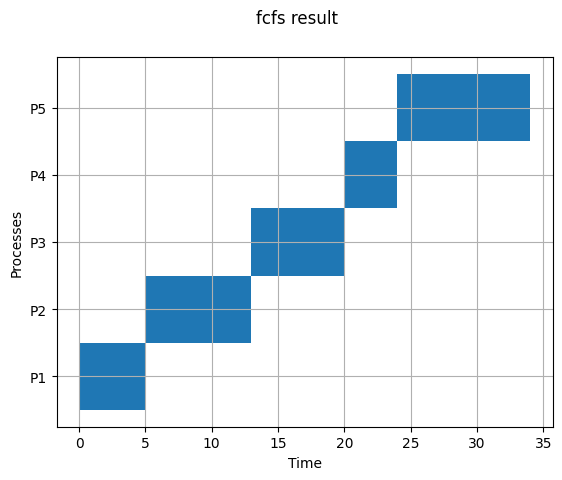

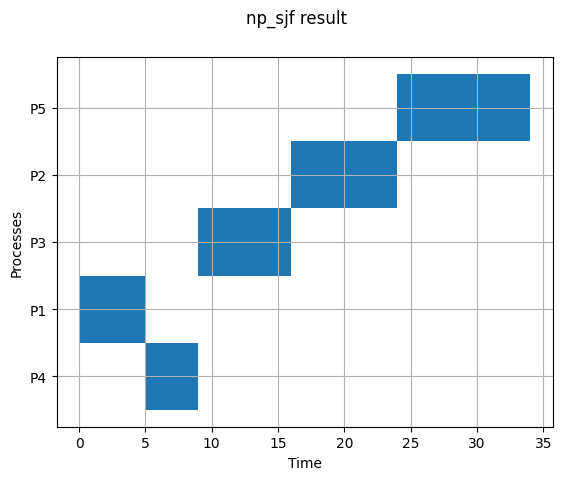

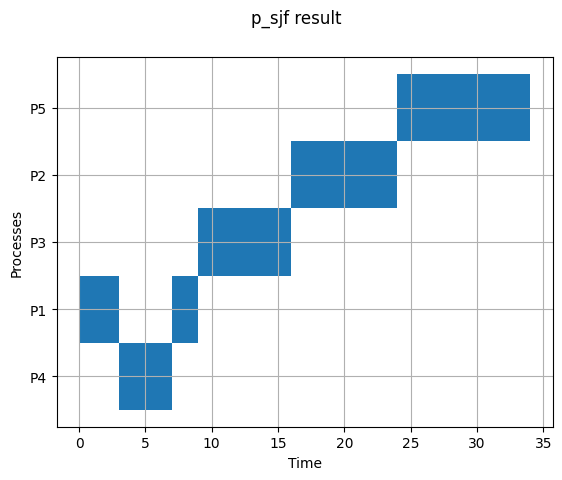

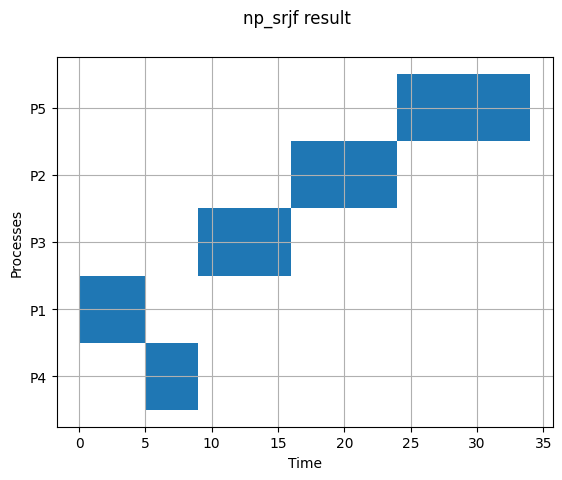

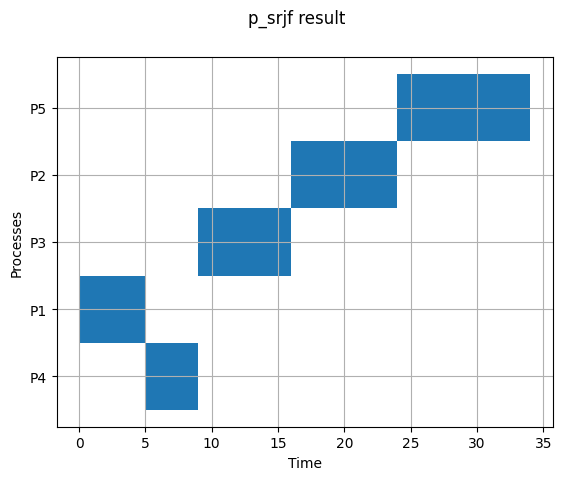

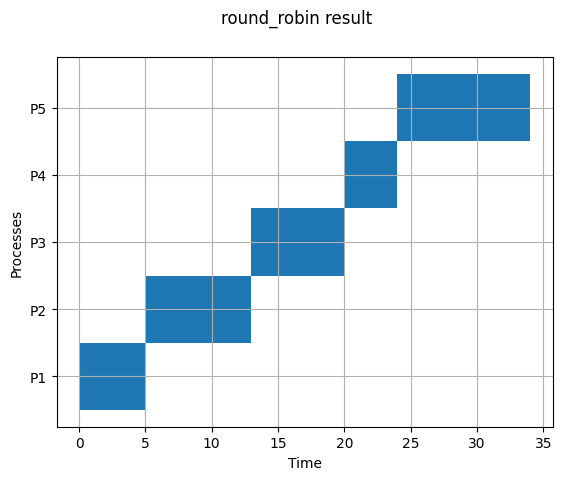

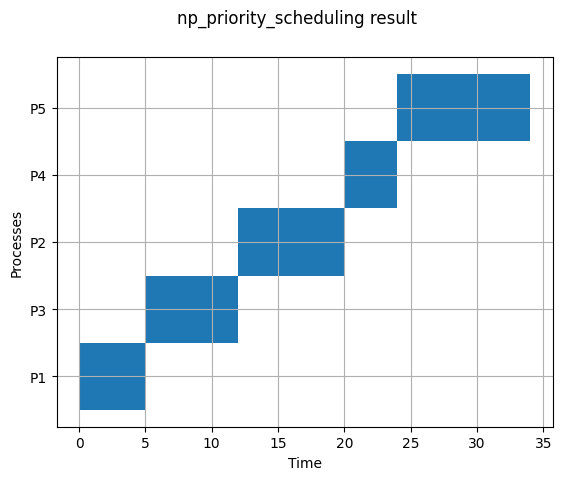

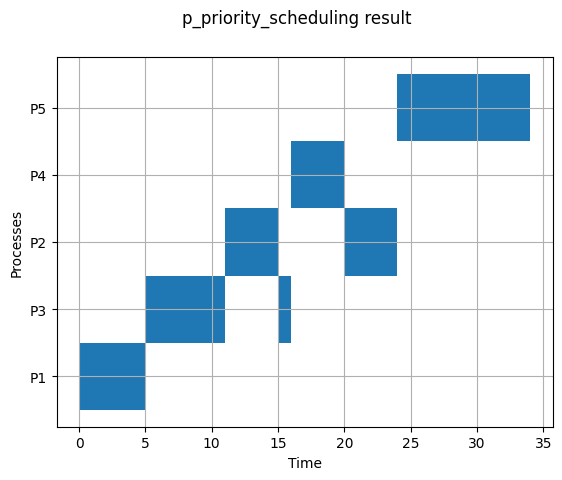

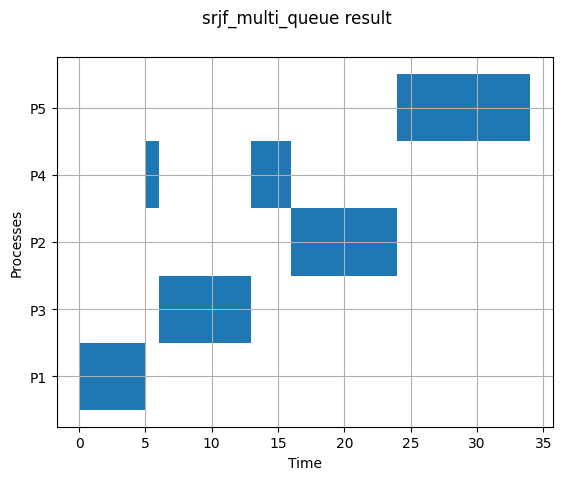

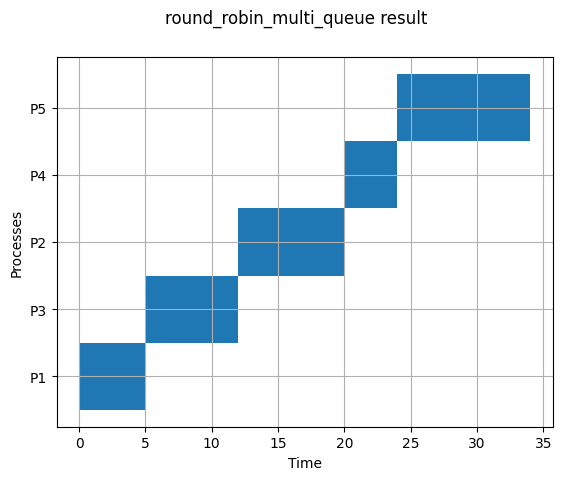

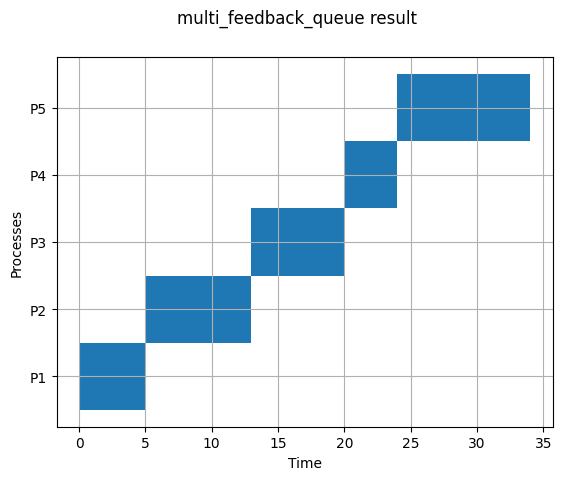

p_srjf is proper_scheduling 
context_switch rank is 1 throughput rank is 1 turnaround_time rank is 1 waiting_time rank is 1 response_time rank is 3 
np_srjf is proper_scheduling 
context_switch rank is 1 throughput rank is 1 turnaround_time rank is 1 waiting_time rank is 1 response_time rank is 3 
np_sjf is proper_scheduling 
context_switch rank is 1 throughput rank is 1 turnaround_time rank is 1 waiting_time rank is 1 response_time rank is 3 
                         Context switch  Throughput  Turnaround time   
Algorithm                                                              
fcfs                                  0        0.12              8.0  \
np_sjf                                0        0.14              7.4   
p_sjf                                 2        0.15              6.6   
np_srjf                               0        0.14              7.4   
p_srjf                                1        0.16              6.4   
round_robin                           0        0

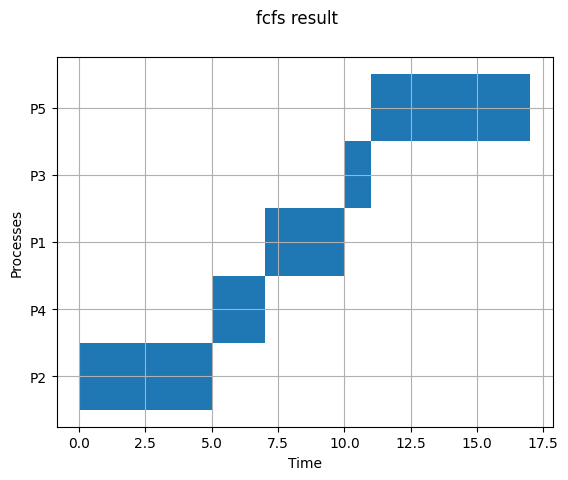

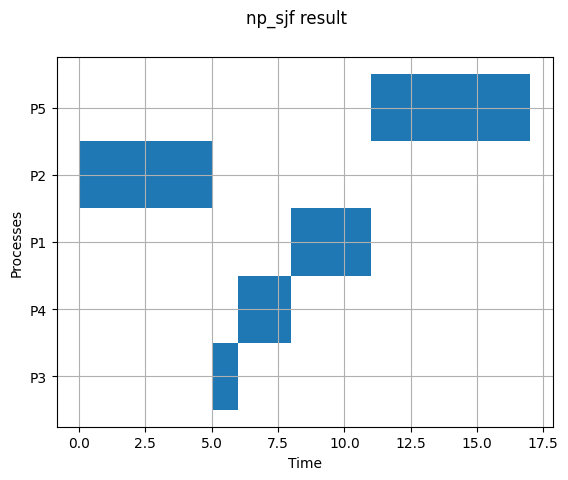

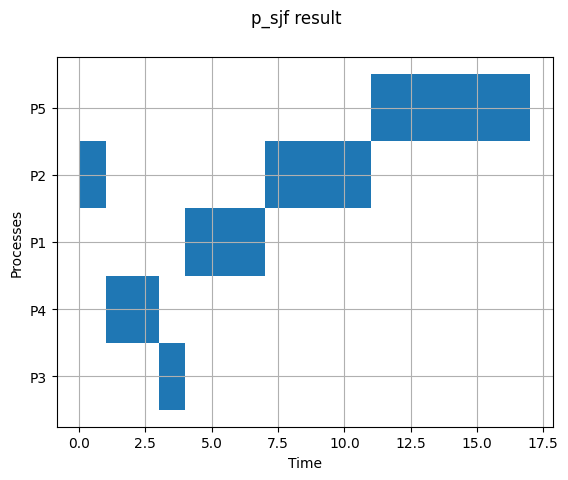

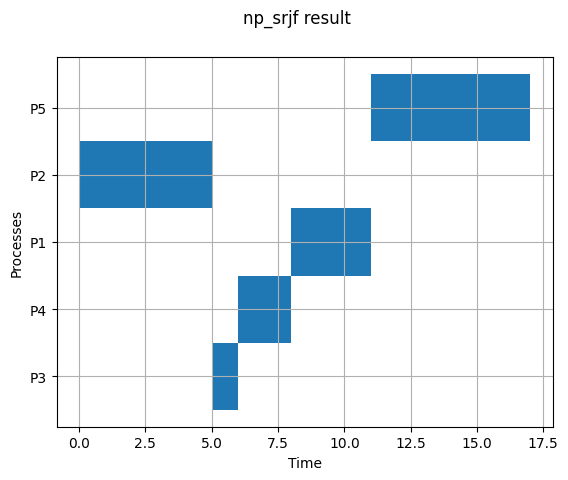

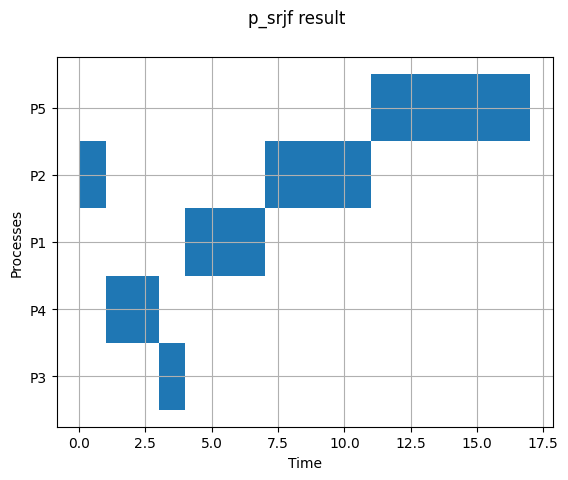

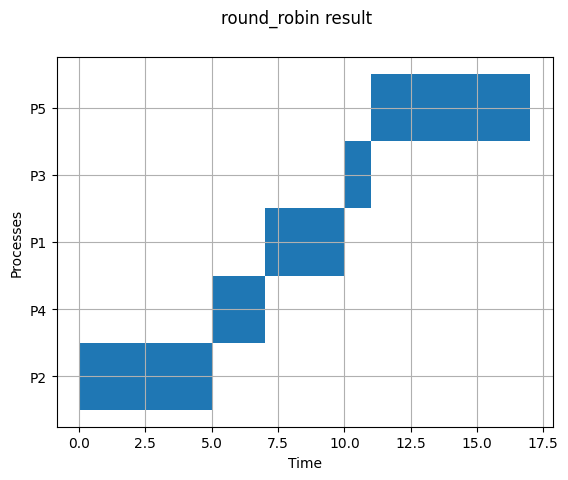

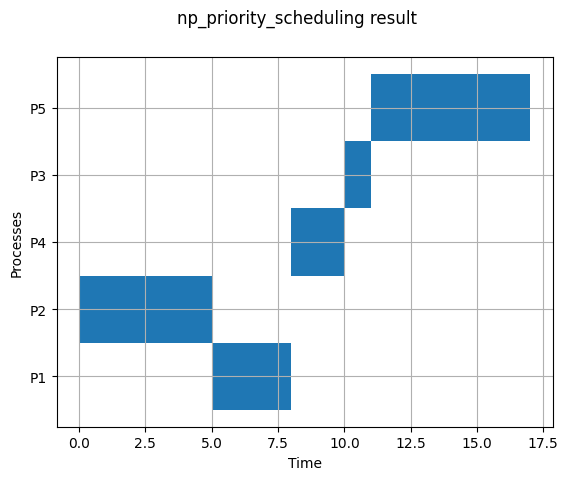

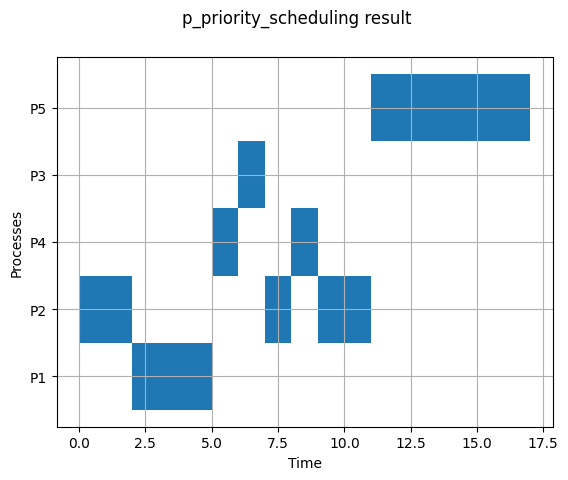

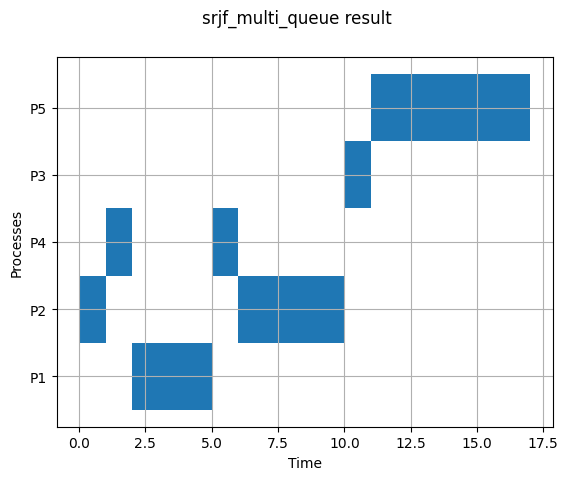

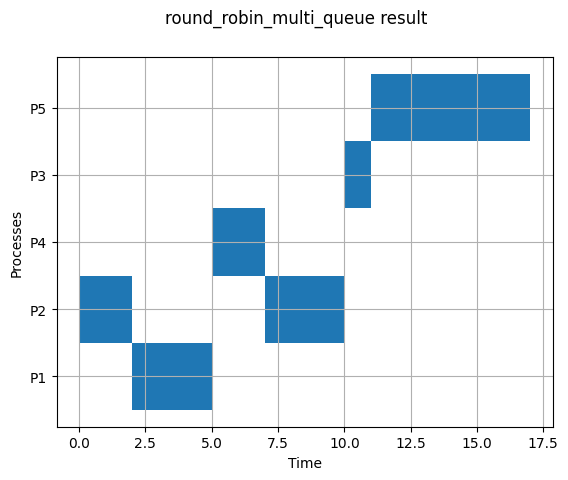

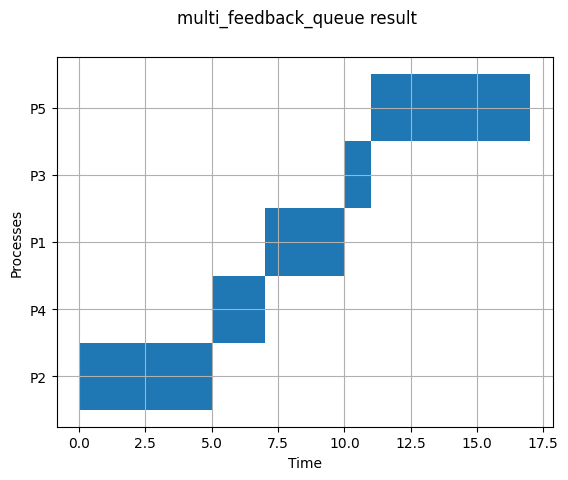

p_srjf is proper_scheduling 
context_switch rank is 7 throughput rank is 11 turnaround_time rank is 1 waiting_time rank is 1 response_time rank is 1 
np_srjf is proper_scheduling 
context_switch rank is 1 throughput rank is 8 turnaround_time rank is 3 waiting_time rank is 3 response_time rank is 6 
np_sjf is proper_scheduling 
context_switch rank is 1 throughput rank is 8 turnaround_time rank is 3 waiting_time rank is 3 response_time rank is 6 
                         Context switch  Throughput  Turnaround time   
Algorithm                                                              
fcfs                                  0        0.04            26.00  \
np_sjf                                0        0.04            26.00   
p_sjf                                 1        0.08            12.67   
np_srjf                               0        0.04            26.00   
p_srjf                                1        0.08            12.67   
round_robin                           1        

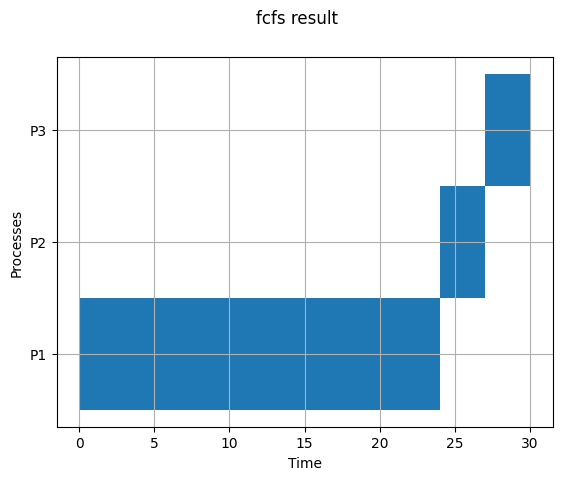

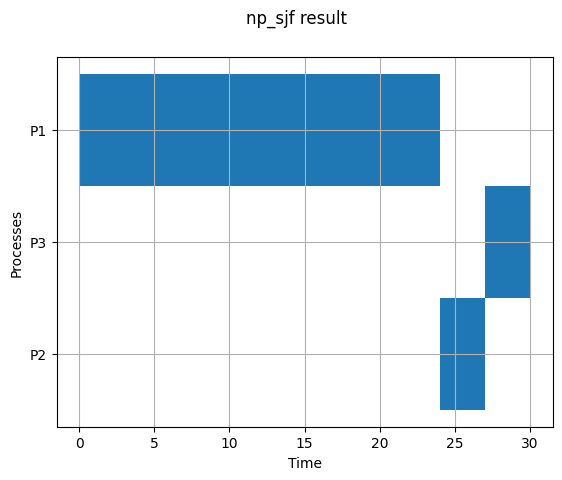

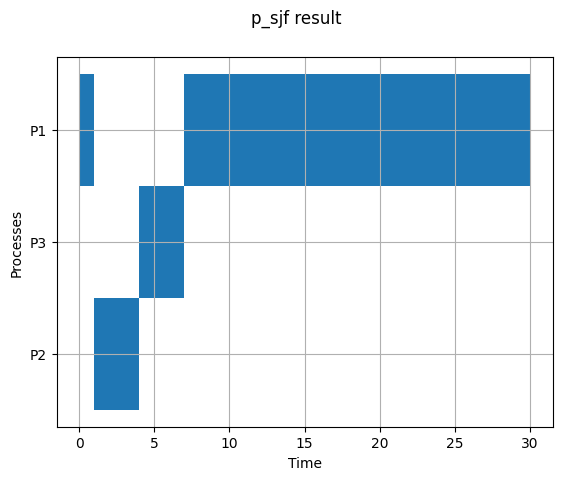

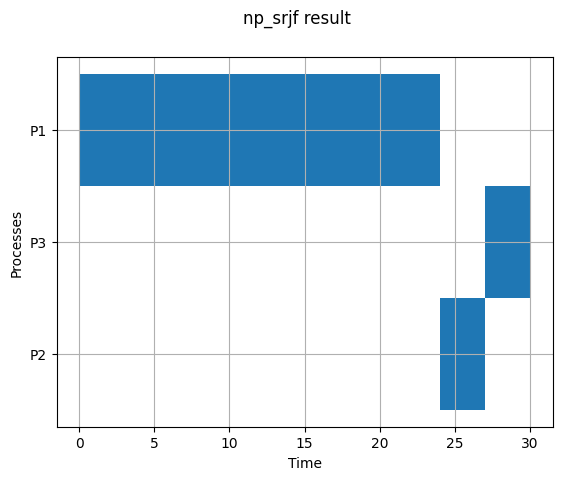

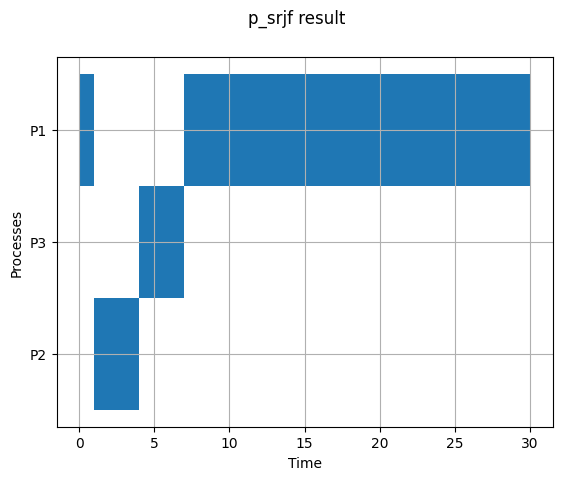

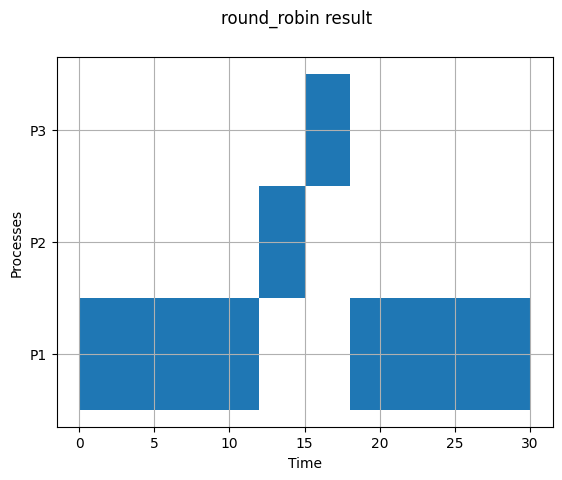

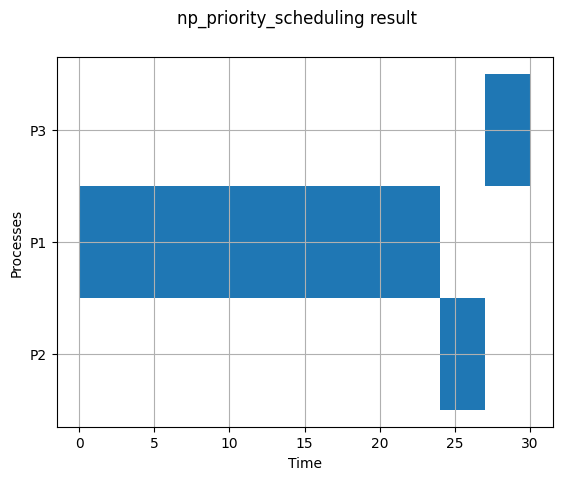

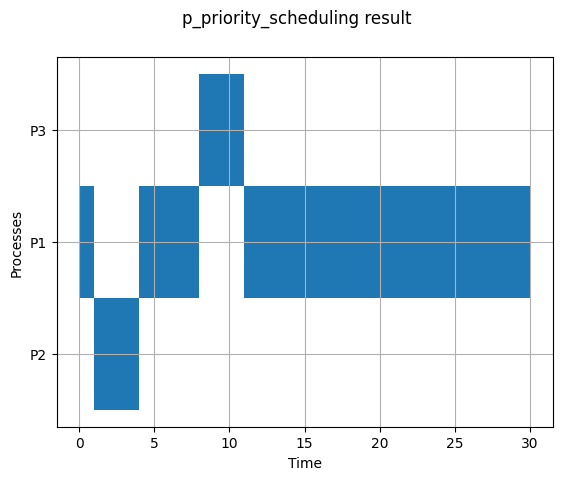

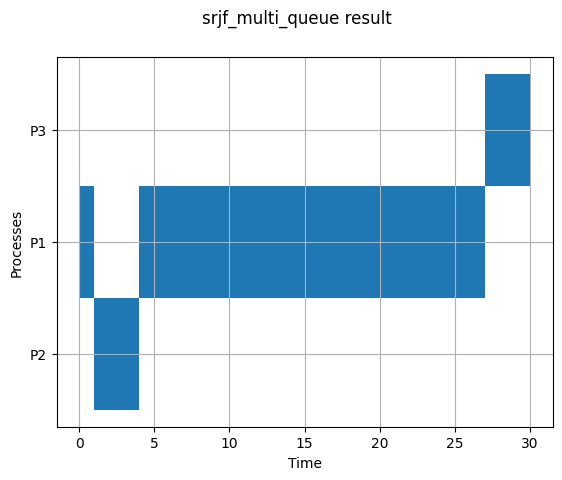

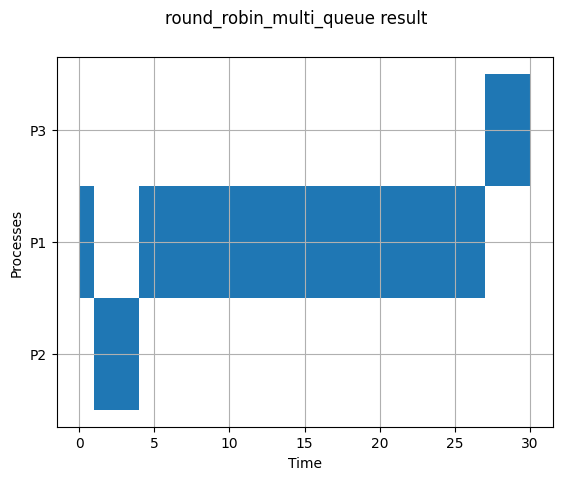

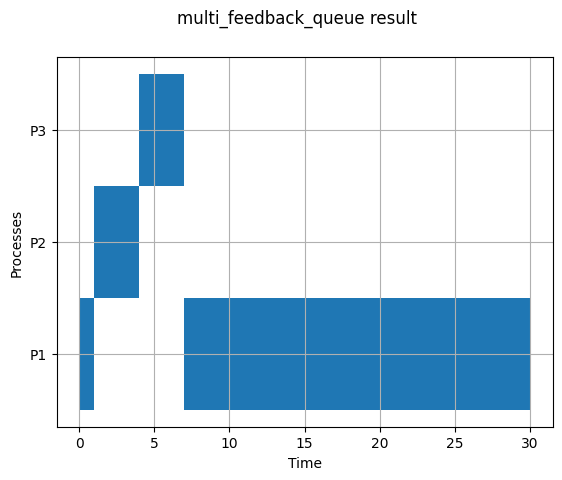

multi_feedback_queue is proper_scheduling 
context_switch rank is 5 throughput rank is 9 turnaround_time rank is 1 waiting_time rank is 1 response_time rank is 1 
p_srjf is proper_scheduling 
context_switch rank is 5 throughput rank is 9 turnaround_time rank is 1 waiting_time rank is 1 response_time rank is 1 
p_sjf is proper_scheduling 
context_switch rank is 5 throughput rank is 9 turnaround_time rank is 1 waiting_time rank is 1 response_time rank is 1 
                              Context switch    Throughput  Turnaround time   
Algorithm                                                                     
realtime_priority_scheduling       987654321  9.876543e+08      987654321.0  \
rate_monotonic                     987654321  9.876543e+08      987654321.0   
edf                                        2  3.000000e-02             32.4   

                              Waiting Time  Response Time  
Algorithm                                                  
realtime_priority_schedu

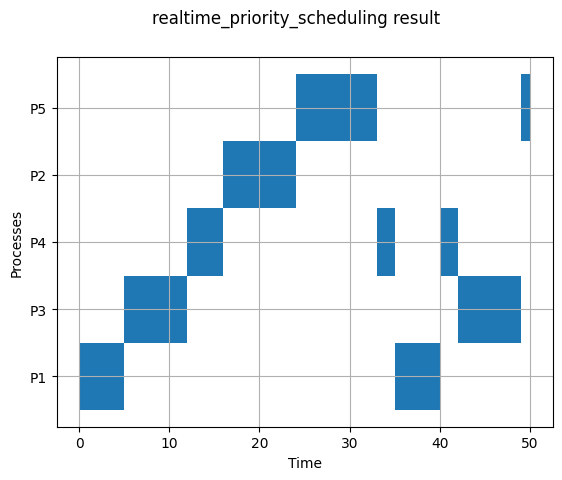

deadline missed for P5 


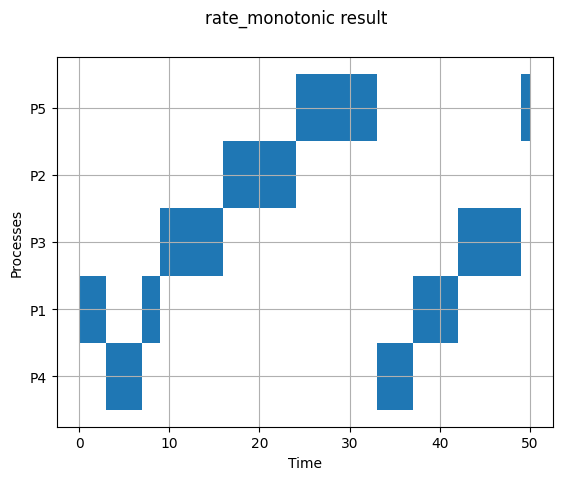

deadline missed for P5 


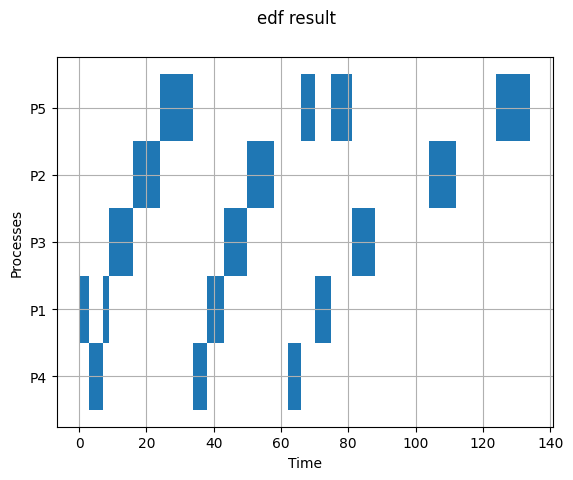

edf is proper_scheduling 
context_switch rank is 1 throughput rank is 1 turnaround_time rank is 1 waiting_time rank is 1 response_time rank is 1 
                              Context switch    Throughput  Turnaround time   
Algorithm                                                                     
realtime_priority_scheduling       987654321  9.876543e+08      987654321.0  \
rate_monotonic                             6  6.000000e-02             17.4   
edf                                        4  6.000000e-02             16.4   

                              Waiting Time  Response Time  
Algorithm                                                  
realtime_priority_scheduling   987654321.0    987654321.0  
rate_monotonic                         7.2            1.8  
edf                                    6.2            1.8  


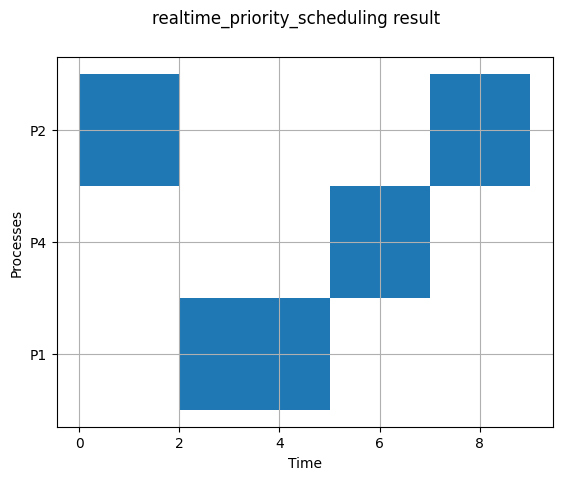

deadline missed for P3 


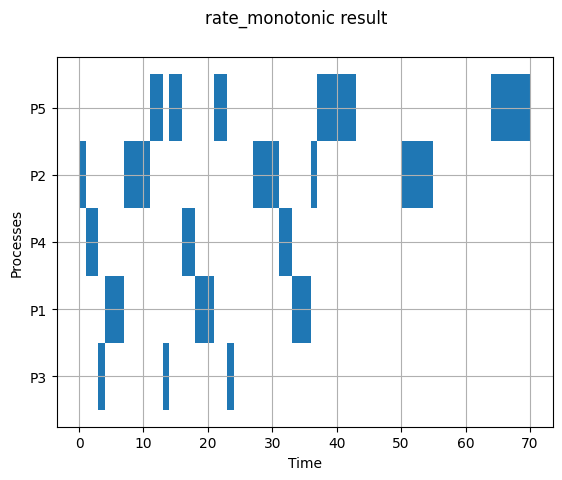

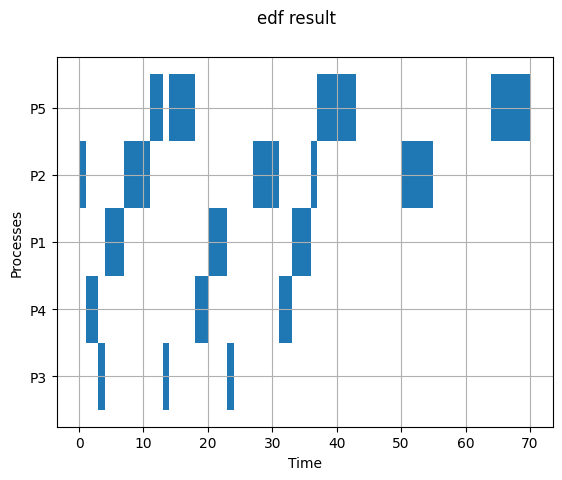

edf is proper_scheduling 
context_switch rank is 1 throughput rank is 1 turnaround_time rank is 1 waiting_time rank is 1 response_time rank is 1 
                              Context switch    Throughput  Turnaround time   
Algorithm                                                                     
realtime_priority_scheduling       987654321  9.876543e+08      987654321.0  \
rate_monotonic                     987654321  9.876543e+08      987654321.0   
edf                                        1  1.000000e-02            122.5   

                              Waiting Time  Response Time  
Algorithm                                                  
realtime_priority_scheduling   987654321.0    987654321.0  
rate_monotonic                 987654321.0    987654321.0  
edf                                   32.5           12.5  


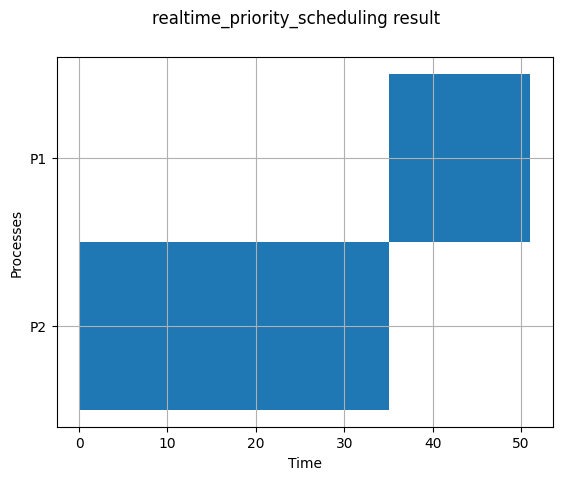

deadline missed for P1 


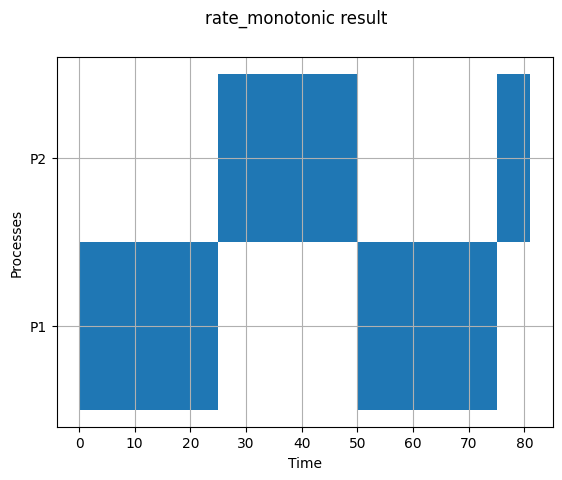

deadline missed for P2 


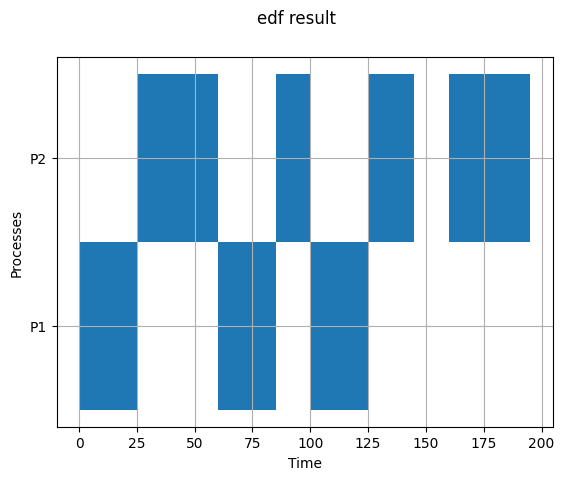

edf is proper_scheduling 
context_switch rank is 1 throughput rank is 1 turnaround_time rank is 1 waiting_time rank is 1 response_time rank is 1 


In [109]:

for task in non_real_tasks:
    non_real_solve(task)
    
for task in real_tasks:
    real_solve(task)